In [1]:
import os
import pandas as pd
import sklearn.metrics
import numpy as np
import plotnine as p9
import optuna
import scipy.stats as stats 
import itertools
import warnings
warnings.filterwarnings('ignore')

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
TRIALS = 250
TOP_N = 1

In [3]:
def load_performance_metrics(dataset, gnn, llm, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(TOP_N) # .head(3) for R8, BART-large due to exceptions
  
  performance = list()
  #for trial in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{x}')]:
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    for random_state in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])

In [4]:
def remove_trials_with_exceptions(df):
  return df.groupby(['trial']).filter(lambda x : len(x) >= 10 * 2).reset_index(drop = True)

In [5]:
def get_best_results(dataset, gnn, llm, method, aggregation, target_metric):
  df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation, display_information = True)
  df = remove_trials_with_exceptions(df)
  df_aggregated = df.groupby(['trial', 'split']).agg({
    'accuracy' : ['mean', 'std'],
    'f1_score' : ['mean', 'std'],
    'precision' : ['mean', 'std'],
    'recall' : ['mean', 'std'],
  }).reset_index()
  df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
  
  best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

  best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

  print(best_trial_number)
  print('-' * 10, 'Validation', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_std'].values[0] * 100, decimals = 2))
  )

  print('-' * 10, 'Test', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±', 
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_std'].values[0] * 100, decimals = 2))
  )


# RQ 3

---------

## SST-2

In [6]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'facebook-bart-base', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     141
value                                 0.925459
params_attention_heads                      12
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                          121
params_beta_0                         0.846054
params_beta_1                         0.998926
params_dropout_rate                   0.442588
params_early_stopping_patience              21
params_embedding_pooling_operation         max
params_epochs                               63
params_epsilon                        0.000002
params_global_pooling                      max
params_hidden_dimension                     58
params_learning_rate                  0.003539
params_number_of_hidden_layers               4
params_plateau_divider                       4
params_plateau_patience                     12
params_threshold                      0.662727
params_weight_decay                   0.000078
user_attrs_ep

In [7]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'FacebookAI-roberta-base', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     104
value                                 0.926606
params_attention_heads                      13
params_attention_pooling_operation        mean
params_balanced_loss                      True
params_batch_size                          197
params_beta_0                         0.823075
params_beta_1                         0.997793
params_dropout_rate                   0.525168
params_early_stopping_patience              11
params_embedding_pooling_operation         max
params_epochs                              178
params_epsilon                        0.000029
params_global_pooling                      max
params_hidden_dimension                    162
params_learning_rate                  0.001031
params_number_of_hidden_layers               1
params_plateau_divider                       9
params_plateau_patience                     23
params_threshold                      0.663891
params_weight_decay                    0.00002
user_attrs_ep

In [8]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'xlnet-xlnet-base-cased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     170
value                                 0.900229
params_attention_heads                      13
params_attention_pooling_operation        mean
params_balanced_loss                      True
params_batch_size                          186
params_beta_0                         0.824953
params_beta_1                         0.982167
params_dropout_rate                   0.312478
params_early_stopping_patience              24
params_embedding_pooling_operation        mean
params_epochs                               58
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    251
params_learning_rate                  0.001303
params_number_of_hidden_layers               4
params_plateau_divider                       4
params_plateau_patience                     13
params_threshold                      0.533083
params_weight_decay                   0.000007
user_attrs_ep

---------

## R8

In [9]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'facebook-bart-base', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     170
value                                 0.968568
params_attention_heads                       6
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                          163
params_beta_0                         0.848785
params_beta_1                         0.994063
params_dropout_rate                   0.324637
params_early_stopping_patience              20
params_embedding_pooling_operation         max
params_epochs                              116
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    132
params_learning_rate                  0.000106
params_left_stride                         128
params_number_of_hidden_layers               2
params_plateau_divider                       4
params_plateau_patience                     12
params_right_stride                          0
params_thresh

In [10]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'FacebookAI-roberta-base', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     239
value                                 0.960833
params_attention_heads                       4
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                          224
params_beta_0                         0.817485
params_beta_1                         0.982257
params_dropout_rate                   0.343777
params_early_stopping_patience              19
params_embedding_pooling_operation        mean
params_epochs                              156
params_epsilon                        0.000046
params_global_pooling                      max
params_hidden_dimension                     89
params_learning_rate                  0.000693
params_left_stride                          32
params_number_of_hidden_layers               0
params_plateau_divider                      10
params_plateau_patience                     16
params_right_stride                        128
params_thresh

In [11]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'xlnet-xlnet-base-cased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     125
value                                 0.956476
params_attention_heads                       6
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                          120
params_beta_0                         0.853204
params_beta_1                         0.987658
params_dropout_rate                   0.330269
params_early_stopping_patience              20
params_embedding_pooling_operation         min
params_epochs                               77
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                    124
params_learning_rate                  0.000188
params_number_of_hidden_layers               0
params_plateau_divider                       3
params_plateau_patience                     16
params_threshold                      0.780541
params_weight_decay                   0.000001
user_attrs_ep

## Ohsumed

In [12]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'facebook-bart-base', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     224
value                                 0.629495
params_attention_heads                       4
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                          105
params_beta_0                         0.810466
params_beta_1                         0.987975
params_dropout_rate                   0.416937
params_early_stopping_patience              20
params_embedding_pooling_operation        mean
params_epochs                              161
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                    141
params_learning_rate                  0.001984
params_left_stride                          32
params_number_of_hidden_layers               1
params_plateau_divider                       5
params_plateau_patience                     14
params_right_stride                         64
params_thresh

In [13]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'FacebookAI-roberta-base', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     134
value                                 0.651157
params_attention_heads                       7
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           78
params_beta_0                         0.899905
params_beta_1                         0.990864
params_dropout_rate                   0.432687
params_early_stopping_patience              25
params_embedding_pooling_operation         max
params_epochs                               59
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                     88
params_learning_rate                   0.00312
params_left_stride                          32
params_number_of_hidden_layers               1
params_plateau_divider                       5
params_plateau_patience                     17
params_right_stride                        128
params_thresh

In [14]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'xlnet-xlnet-base-cased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     146
value                                 0.623122
params_attention_heads                       5
params_attention_pooling_operation         max
params_balanced_loss                      True
params_batch_size                           94
params_beta_0                         0.841119
params_beta_1                          0.98596
params_dropout_rate                   0.350983
params_early_stopping_patience              22
params_embedding_pooling_operation         max
params_epochs                              100
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                    162
params_learning_rate                  0.001237
params_number_of_hidden_layers               1
params_plateau_divider                      10
params_plateau_patience                     17
params_threshold                      0.816495
params_weight_decay                   0.000072
user_attrs_ep

## IMDb Top 1k

In [15]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'facebook-bart-base', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     238
value                                 0.945455
params_attention_heads                       4
params_attention_pooling_operation        mean
params_balanced_loss                      True
params_batch_size                           35
params_beta_0                           0.8409
params_beta_1                         0.983315
params_dropout_rate                   0.525447
params_early_stopping_patience              21
params_embedding_pooling_operation        mean
params_epochs                               71
params_epsilon                        0.000019
params_global_pooling                      sum
params_hidden_dimension                    135
params_learning_rate                  0.002497
params_left_stride                          64
params_number_of_hidden_layers               2
params_plateau_divider                       3
params_plateau_patience                     18
params_right_stride                          0
params_thresh

In [16]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'FacebookAI-roberta-base', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     174
value                                 0.951515
params_attention_heads                       5
params_attention_pooling_operation        mean
params_balanced_loss                     False
params_batch_size                           54
params_beta_0                         0.815295
params_beta_1                          0.99656
params_dropout_rate                   0.599626
params_early_stopping_patience              17
params_embedding_pooling_operation         min
params_epochs                              146
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                     41
params_learning_rate                  0.001821
params_left_stride                          64
params_number_of_hidden_layers               1
params_plateau_divider                       8
params_plateau_patience                     13
params_right_stride                          0
params_thresh

In [17]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'xlnet-xlnet-base-cased', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     371
value                                 0.951515
params_attention_heads                      13
params_attention_pooling_operation         max
params_balanced_loss                      True
params_batch_size                           40
params_beta_0                         0.855274
params_beta_1                         0.990326
params_dropout_rate                   0.442699
params_early_stopping_patience              13
params_embedding_pooling_operation         min
params_epochs                              156
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                     41
params_learning_rate                  0.004868
params_number_of_hidden_layers               0
params_plateau_divider                       7
params_plateau_patience                     17
params_threshold                      0.993168
params_weight_decay                   0.000021
user_attrs_ep

## Visual analysis

In [18]:
def get_best_results_for_plot(datasets, gnns, llms, methods, aggregations, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for llm in llms:
        for method in methods:
          for aggregation in aggregations:
            df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
            df = remove_trials_with_exceptions(df)
            df_aggregated = df.groupby(['trial', 'split']).agg({
              'accuracy' : ['mean', 'std'],
              'f1_score' : ['mean', 'std'],
              'precision' : ['mean', 'std'],
              'recall' : ['mean', 'std'],
            }).reset_index()
            df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
            
            best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

            best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

            best_trial_validation = best_trial[best_trial['split'] == 'validation']
            best_trial_test = best_trial[best_trial['split'] == 'test']

            results.append((dataset, target_metric, gnn, llm, method, aggregation, best_trial_validation['accuracy_mean'].values[0], best_trial_validation['accuracy_std'].values[0], \
              best_trial_validation['f1_score_mean'].values[0], best_trial_validation['f1_score_std'].values[0], \
              best_trial_validation['precision_mean'].values[0], best_trial_validation['precision_std'].values[0], \
              best_trial_validation['recall_mean'].values[0], best_trial_validation['recall_std'].values[0], \
              best_trial_test['accuracy_mean'].values[0], best_trial_test['accuracy_std'].values[0], \
              best_trial_test['f1_score_mean'].values[0], best_trial_test['f1_score_std'].values[0], \
              best_trial_test['precision_mean'].values[0], best_trial_test['precision_std'].values[0], \
              best_trial_test['recall_mean'].values[0], best_trial_test['recall_std'].values[0]))
  return pd.DataFrame(
    results,
    columns = ['dataset', 'target_metric', 'gnn', 'llm', 'method', 'aggregation', 'validation_accuracy_mean', 'validation_accuracy_std', 'validation_f1_score_mean', 'validation_f1_score_std', \
              'validation_precision_mean', 'validation_precision_std', 'validation_recall_mean', 'validation_recall_std', 'test_accuracy_mean', 'test_accuracy_std', \
              'test_f1_score_mean', 'test_f1_score_std', 'test_precision_mean', 'test_precision_std', 'test_recall_mean', 'test_recall_std']
  )

In [19]:
best_results_df = get_best_results_for_plot(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llms = ['google-bert-bert-base-uncased', 'facebook-bart-base', 'FacebookAI-roberta-base', 'xlnet-xlnet-base-cased'],
  methods = ['Grouped'],
  aggregations = ['No_Aggregation']
)

In [20]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GATv2,google-bert-bert-base-uncased,Grouped,No_Aggregation,0.902294,0.003096,0.902275,0.003101,...,0.902429,0.003134,0.895167,0.007491,0.895155,0.007502,0.895350,0.007336,0.895169,0.007484
1,SST-2,accuracy,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.915596,0.004194,0.915550,0.004214,...,0.915606,0.004247,0.918561,0.005184,0.918523,0.005202,0.919382,0.005026,0.918582,0.005190
2,SST-2,accuracy,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.921216,0.003060,0.921201,0.003066,...,0.921536,0.003134,0.922680,0.002269,0.922662,0.002278,0.923042,0.002148,0.922669,0.002271
3,SST-2,accuracy,GATv2,xlnet-xlnet-base-cased,Grouped,No_Aggregation,0.890596,0.005247,0.890573,0.005250,...,0.890728,0.005219,0.876771,0.004160,0.876735,0.004169,0.877170,0.004086,0.876758,0.004159
4,R8,f1_score,GATv2,google-bert-bert-base-uncased,Grouped,No_Aggregation,0.978122,0.002718,0.953193,0.004542,...,0.958557,0.006382,0.978483,0.002497,0.946604,0.004902,0.950180,0.007487,0.944694,0.006340
5,R8,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.979945,0.001664,0.950488,0.005558,...,0.956030,0.007546,0.977798,0.002271,0.943850,0.006065,0.952309,0.006760,0.936925,0.005840
6,R8,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.980492,0.001675,0.951333,0.005582,...,0.963495,0.005226,0.977524,0.001094,0.939366,0.005070,0.951990,0.005807,0.929869,0.004254
7,R8,f1_score,GATv2,xlnet-xlnet-base-cased,Grouped,No_Aggregation,0.961531,0.001863,0.942277,0.006689,...,0.940925,0.007565,0.961352,0.005218,0.909728,0.009352,0.932976,0.009199,0.893185,0.011245
8,Ohsumed,f1_score,GATv2,google-bert-bert-base-uncased,Grouped,No_Aggregation,0.715476,0.007837,0.637028,0.013302,...,0.634265,0.011414,0.699629,0.005115,0.613479,0.005422,0.622005,0.007952,0.616470,0.005330
9,Ohsumed,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.709673,0.006174,0.608981,0.013366,...,0.604547,0.015281,0.716003,0.007080,0.627257,0.010538,0.649748,0.012749,0.622424,0.009265


## Rank analysis

In [21]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_rank'] = best_results_df[['dataset', column]].groupby(['dataset']).rank(method = 'max', ascending = False)

In [22]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,test_recall_mean,test_recall_std,validation_accuracy_mean_rank,validation_f1_score_mean_rank,validation_precision_mean_rank,validation_recall_mean_rank,test_accuracy_mean_rank,test_f1_score_mean_rank,test_precision_mean_rank,test_recall_mean_rank
0,SST-2,accuracy,GATv2,google-bert-bert-base-uncased,Grouped,No_Aggregation,0.902294,0.003096,0.902275,0.003101,...,0.895169,0.007484,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,SST-2,accuracy,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.915596,0.004194,0.915550,0.004214,...,0.918582,0.005190,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2,SST-2,accuracy,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.921216,0.003060,0.921201,0.003066,...,0.922669,0.002271,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,SST-2,accuracy,GATv2,xlnet-xlnet-base-cased,Grouped,No_Aggregation,0.890596,0.005247,0.890573,0.005250,...,0.876758,0.004159,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
4,R8,f1_score,GATv2,google-bert-bert-base-uncased,Grouped,No_Aggregation,0.978122,0.002718,0.953193,0.004542,...,0.944694,0.006340,3.0,1.0,1.0,2.0,1.0,1.0,3.0,1.0
5,R8,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.979945,0.001664,0.950488,0.005558,...,0.936925,0.005840,2.0,3.0,2.0,3.0,2.0,2.0,1.0,2.0
6,R8,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.980492,0.001675,0.951333,0.005582,...,0.929869,0.004254,1.0,2.0,4.0,1.0,3.0,3.0,2.0,3.0
7,R8,f1_score,GATv2,xlnet-xlnet-base-cased,Grouped,No_Aggregation,0.961531,0.001863,0.942277,0.006689,...,0.893185,0.011245,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0
8,Ohsumed,f1_score,GATv2,google-bert-bert-base-uncased,Grouped,No_Aggregation,0.715476,0.007837,0.637028,0.013302,...,0.616470,0.005330,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0
9,Ohsumed,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.709673,0.006174,0.608981,0.013366,...,0.622424,0.009265,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0


In [23]:
best_results_df_grouped = best_results_df.groupby(['llm']).agg({
  'validation_accuracy_mean_rank' : ['mean', 'std'],
  'test_accuracy_mean_rank' : ['mean', 'std'],
  'validation_f1_score_mean_rank' : ['mean', 'std'],
  'test_f1_score_mean_rank' : ['mean', 'std'],
  'validation_precision_mean_rank' : ['mean', 'std'],
  'test_precision_mean_rank' : ['mean', 'std'],
  'validation_recall_mean_rank' : ['mean', 'std'],
  'test_recall_mean_rank' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [24]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['llm'], var_name = 'information', value_name = 'value') # .drop(columns = ['gnn', 'method'])
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [25]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['llm', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [26]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [27]:
best_results_df_grouped.head()

mean_std,llm,split,metric,mean,std,label
0,FacebookAI-roberta-base,test,accuracy,1.75,0.957427,1.75 ± 0.96
1,FacebookAI-roberta-base,test,f1,1.75,0.957427,1.75 ± 0.96
2,FacebookAI-roberta-base,test,precision,1.50,0.577350,1.50 ± 0.58
3,FacebookAI-roberta-base,test,recall,1.75,0.957427,1.75 ± 0.96
4,FacebookAI-roberta-base,validation,accuracy,1.25,0.500000,1.25 ± 0.50


In [28]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()

In [29]:
best_results_df_grouped['llm'] = best_results_df_grouped['llm'].replace({
  'FacebookAI-roberta-base' : 'RoBERTa',
  'facebook-bart-base' : 'BART',
  'google-bert-bert-base-uncased' : 'BERT',
  'xlnet-xlnet-base-cased' : 'XLNet'
})

In [30]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

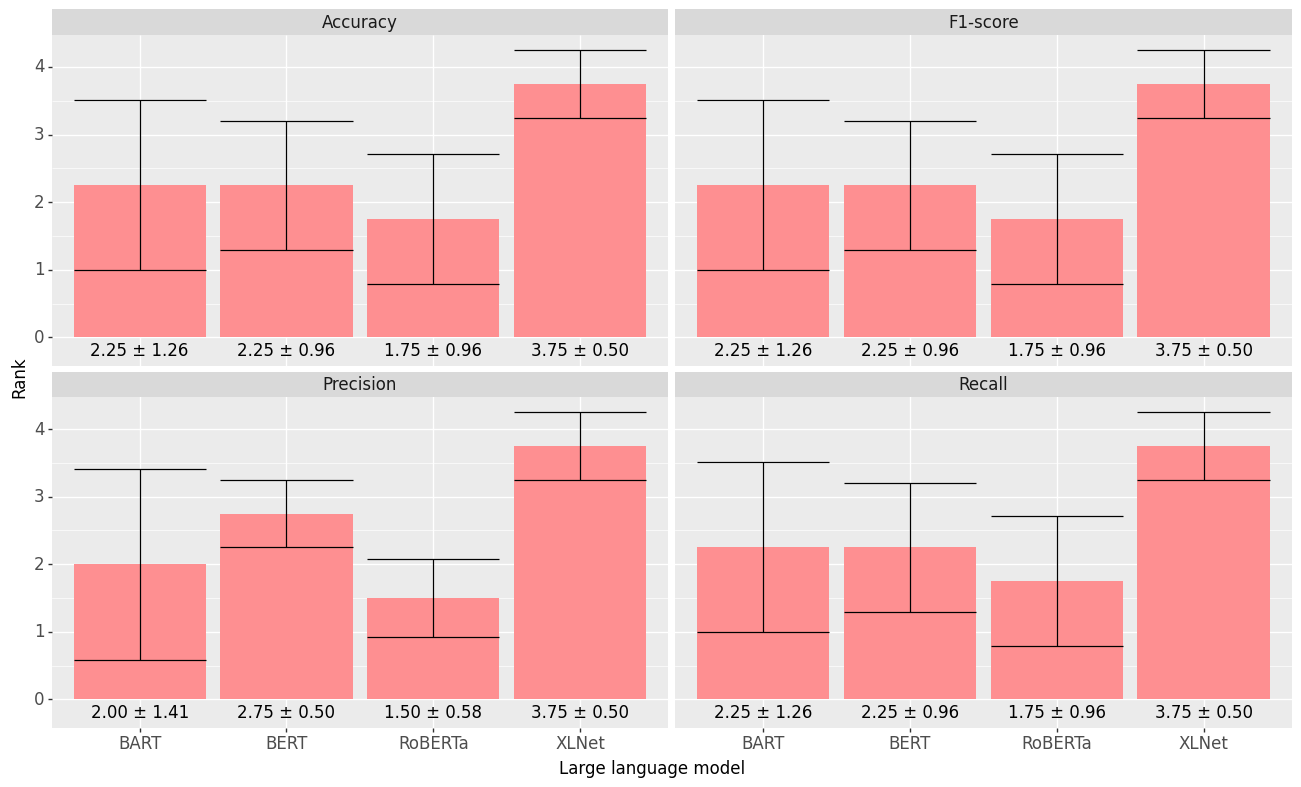

<ggplot: (401178658)>

In [31]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.2, label = 'label'), position = p9.position_dodge2(width = .9), size = 12) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

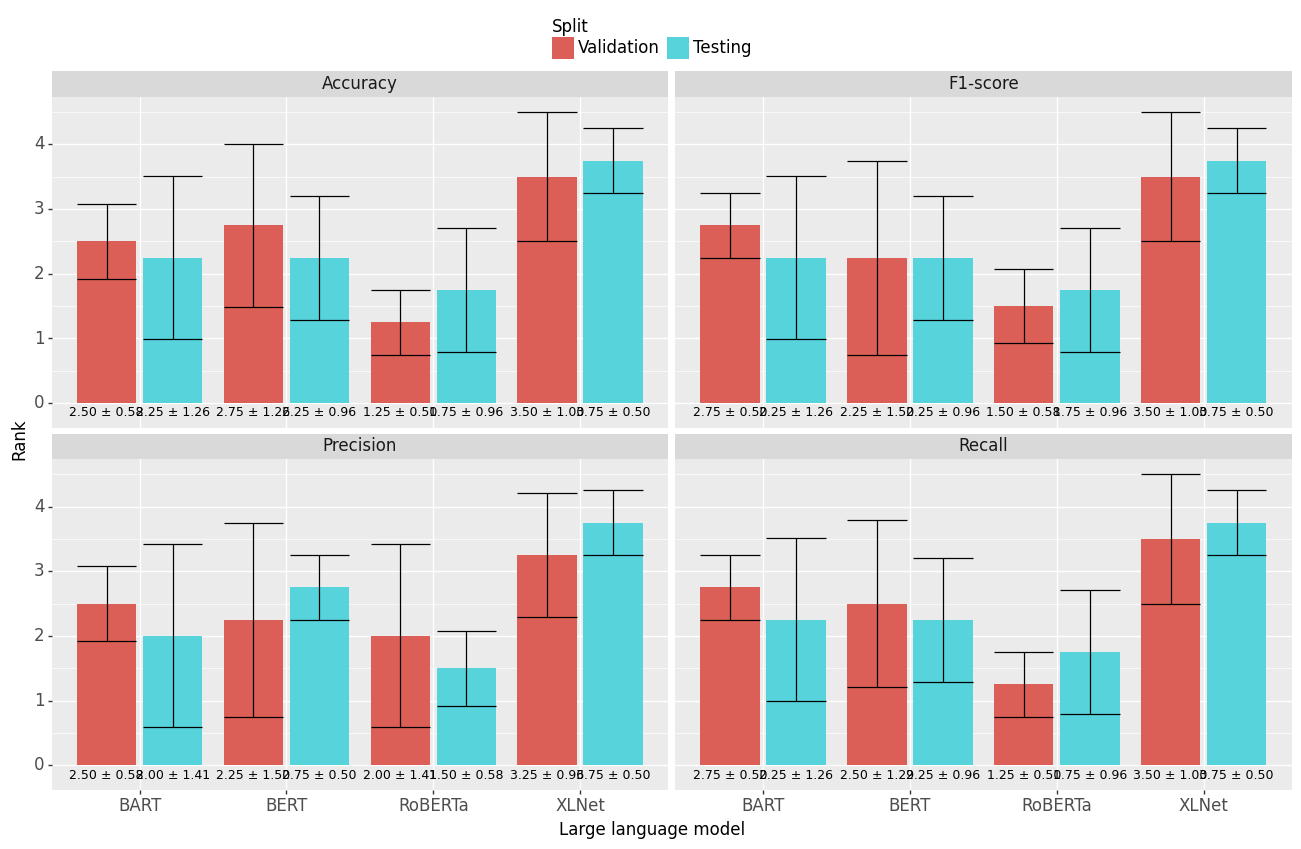

<ggplot: (401829138)>

In [32]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

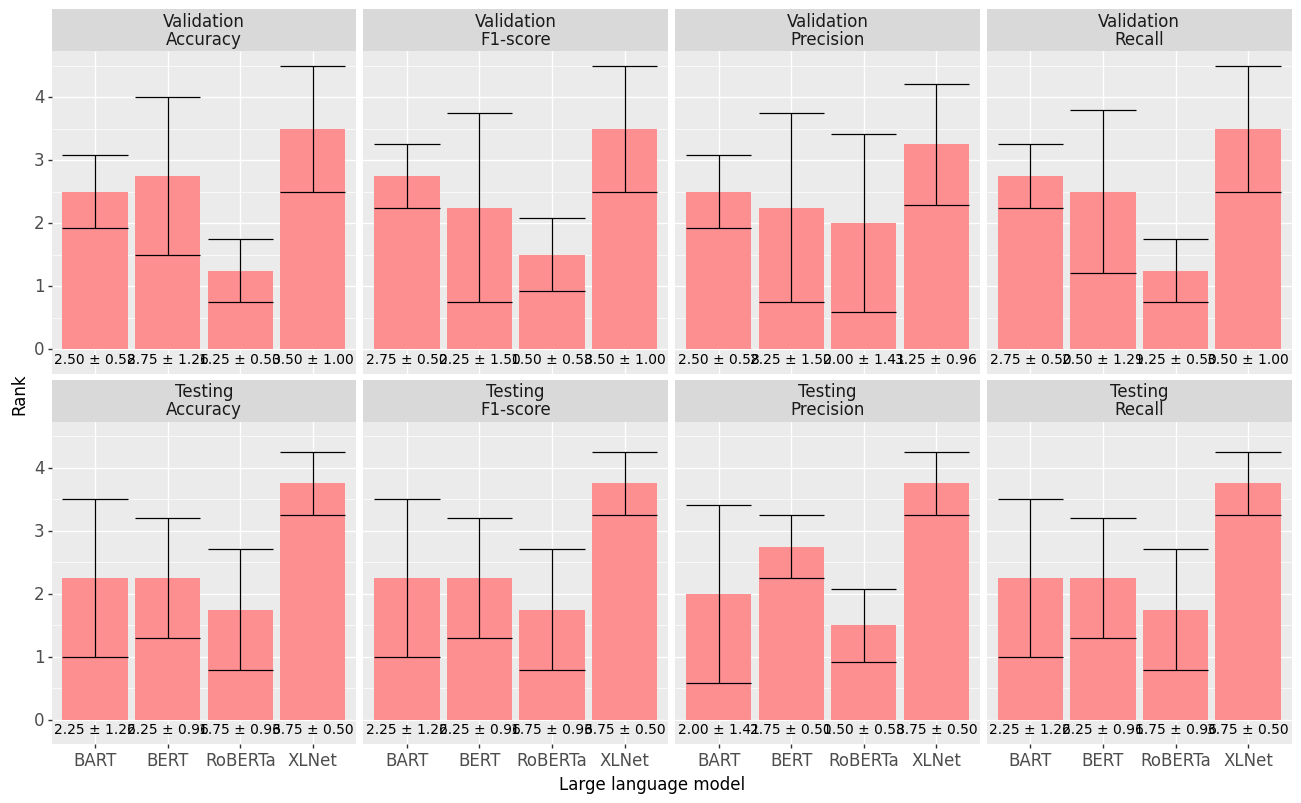

<ggplot: (400971278)>

In [33]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4) + \
  p9.xlab('Large language model') + \
  p9.ylab('Rank') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

## Percentage change analysis

In [34]:
best_results_df.drop(columns = [x for x in best_results_df.columns if x.endswith('_rank')], inplace = True)

In [35]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GATv2,google-bert-bert-base-uncased,Grouped,No_Aggregation,0.902294,0.003096,0.902275,0.003101,...,0.902429,0.003134,0.895167,0.007491,0.895155,0.007502,0.895350,0.007336,0.895169,0.007484
1,SST-2,accuracy,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.915596,0.004194,0.915550,0.004214,...,0.915606,0.004247,0.918561,0.005184,0.918523,0.005202,0.919382,0.005026,0.918582,0.005190
2,SST-2,accuracy,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.921216,0.003060,0.921201,0.003066,...,0.921536,0.003134,0.922680,0.002269,0.922662,0.002278,0.923042,0.002148,0.922669,0.002271
3,SST-2,accuracy,GATv2,xlnet-xlnet-base-cased,Grouped,No_Aggregation,0.890596,0.005247,0.890573,0.005250,...,0.890728,0.005219,0.876771,0.004160,0.876735,0.004169,0.877170,0.004086,0.876758,0.004159
4,R8,f1_score,GATv2,google-bert-bert-base-uncased,Grouped,No_Aggregation,0.978122,0.002718,0.953193,0.004542,...,0.958557,0.006382,0.978483,0.002497,0.946604,0.004902,0.950180,0.007487,0.944694,0.006340
5,R8,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.979945,0.001664,0.950488,0.005558,...,0.956030,0.007546,0.977798,0.002271,0.943850,0.006065,0.952309,0.006760,0.936925,0.005840
6,R8,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.980492,0.001675,0.951333,0.005582,...,0.963495,0.005226,0.977524,0.001094,0.939366,0.005070,0.951990,0.005807,0.929869,0.004254
7,R8,f1_score,GATv2,xlnet-xlnet-base-cased,Grouped,No_Aggregation,0.961531,0.001863,0.942277,0.006689,...,0.940925,0.007565,0.961352,0.005218,0.909728,0.009352,0.932976,0.009199,0.893185,0.011245
8,Ohsumed,f1_score,GATv2,google-bert-bert-base-uncased,Grouped,No_Aggregation,0.715476,0.007837,0.637028,0.013302,...,0.634265,0.011414,0.699629,0.005115,0.613479,0.005422,0.622005,0.007952,0.616470,0.005330
9,Ohsumed,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.709673,0.006174,0.608981,0.013366,...,0.604547,0.015281,0.716003,0.007080,0.627257,0.010538,0.649748,0.012749,0.622424,0.009265


In [36]:
best_results_df['is_base'] = (best_results_df['gnn'] == 'GATv2') & (best_results_df['method'] == 'Grouped') & (best_results_df['aggregation'] == 'No_Aggregation') & (best_results_df['llm'] == 'google-bert-bert-base-uncased')

In [37]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_change'] = best_results_df[['dataset', column, 'is_base']] \
    .groupby(['dataset']) \
    .apply(
      lambda group: group.apply(
        lambda row: ((row[column] - group.loc[group['is_base'], column].values[0]) / group.loc[group['is_base'], column].values[0]) * 100
          if group['is_base'].any() else None, axis = 1
        )
    ).reset_index(drop = True)

In [38]:
best_results_df = best_results_df[~best_results_df['is_base']]

In [39]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,test_recall_std,is_base,validation_accuracy_mean_change,validation_f1_score_mean_change,validation_precision_mean_change,validation_recall_mean_change,test_accuracy_mean_change,test_f1_score_mean_change,test_precision_mean_change,test_recall_mean_change
1,SST-2,accuracy,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.915596,0.004194,0.915550,0.004214,...,0.005190,False,0.797342,0.852496,0.639542,1.087829,-2.329343,-2.335090,-2.249942,-2.289887
2,SST-2,accuracy,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.921216,0.003060,0.921201,0.003066,...,0.002271,False,2.923588,2.950770,2.952911,2.933571,0.744096,0.745195,0.719745,0.718172
3,SST-2,accuracy,GATv2,xlnet-xlnet-base-cased,Grouped,No_Aggregation,0.890596,0.005247,0.890573,0.005250,...,0.004159,False,1.063123,1.108815,1.062665,1.355328,-0.388224,-0.372216,-0.180476,-0.184634
5,R8,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.979945,0.001664,0.950488,0.005558,...,0.005840,False,-0.811148,-4.402766,-5.059914,-4.685356,2.340380,2.245789,4.460379,0.965861
6,R8,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.980492,0.001675,0.951333,0.005582,...,0.004254,False,-0.270383,-1.145211,-3.569685,-0.312499,1.336350,0.284125,0.551868,0.344076
7,R8,f1_score,GATv2,xlnet-xlnet-base-cased,Grouped,No_Aggregation,0.961531,0.001863,0.942277,0.006689,...,0.011245,False,-9.338602,-13.812186,-14.237214,-10.877900,-7.279219,-8.384690,-4.554129,-7.113206
9,Ohsumed,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.709673,0.006174,0.608981,0.013366,...,0.009265,False,0.186393,-0.283775,-0.314329,-0.263587,-0.070031,-0.290973,0.224029,-0.822364
10,Ohsumed,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.713542,0.005579,0.629733,0.005021,...,0.012965,False,0.242311,-0.195088,-0.793581,0.515172,-0.098044,-0.764708,0.190418,-1.569229
11,Ohsumed,f1_score,GATv2,xlnet-xlnet-base-cased,Grouped,No_Aggregation,0.648661,0.047518,0.549041,0.061131,...,0.060921,False,-1.696179,-1.145227,-0.445509,-1.839421,-1.750782,-3.895713,-1.810629,-5.452401
13,IMDb-top_1000,accuracy,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.919394,0.013416,0.919170,0.013389,...,0.006943,False,1.474326,1.471240,1.501176,1.460140,2.613337,2.610535,2.684179,2.615483


In [40]:
best_results_df_melted = best_results_df.drop(columns = ['dataset', 'target_metric', 'gnn', 'method', 'aggregation']).melt(id_vars = ['llm'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_melted['information'].str.split('_')
best_results_df_melted['split'] = split_information_column.str[0]
best_results_df_melted['metric'] = split_information_column.str[1]
best_results_df_melted.drop(columns = ['information'], inplace = True)

In [41]:
best_results_df_melted['metric'] = best_results_df_melted['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_melted['llm'] = best_results_df_melted['llm'].replace({
  'FacebookAI-roberta-base' : 'RoBERTa',
  'facebook-bart-base' : 'BART',
  'google-bert-bert-base-uncased' : 'BERT',
  'xlnet-xlnet-base-cased' : 'XLNet'
})
best_results_df_melted['split'] = best_results_df_melted['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_melted['split'] = pd.Categorical(best_results_df_melted['split'], categories = ['Validation', 'Testing'])

In [42]:
best_results_df_melted['value'] = best_results_df_melted['value'].astype(float)

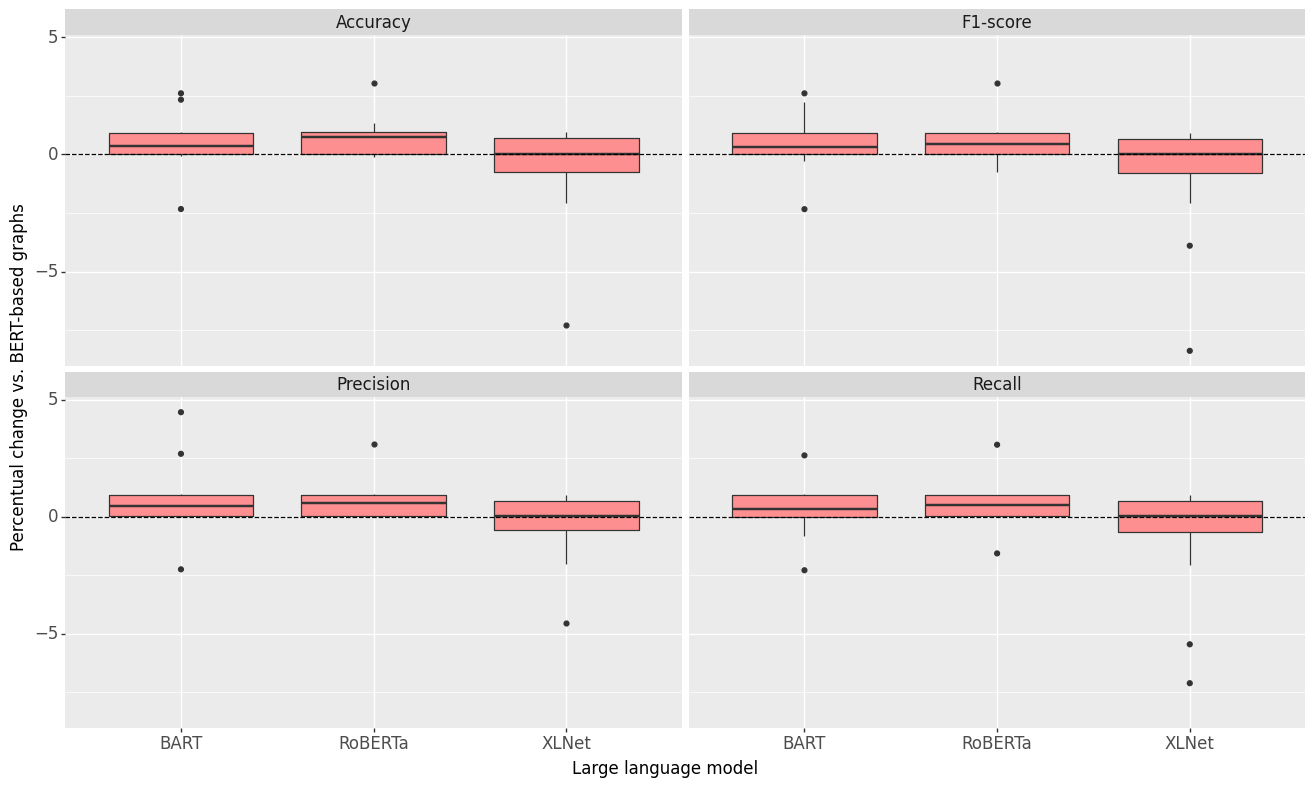

<ggplot: (401892467)>

In [43]:
p9.ggplot(best_results_df_melted[best_results_df_melted['split'] == 'Testing'],
  p9.aes(x = 'llm', y = 'value', group = 'llm')) + \
  p9.theme_gray() + \
  p9.geom_boxplot(fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs. BERT-based graphs') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

In [44]:
best_results_df_grouped = best_results_df.groupby(['llm']).agg({
  'validation_accuracy_mean_change' : ['mean', 'std'],
  'test_accuracy_mean_change' : ['mean', 'std'],
  'validation_f1_score_mean_change' : ['mean', 'std'],
  'test_f1_score_mean_change' : ['mean', 'std'],
  'validation_precision_mean_change' : ['mean', 'std'],
  'test_precision_mean_change' : ['mean', 'std'],
  'validation_recall_mean_change' : ['mean', 'std'],
  'test_recall_mean_change' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [45]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['llm'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [46]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['llm', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [47]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [48]:
best_results_df_grouped.head()

mean_std,llm,split,metric,mean,std,label
0,FacebookAI-roberta-base,test,accuracy,1.263958,1.342229,1.26 ± 1.34
1,FacebookAI-roberta-base,test,f1,0.834370,1.620560,0.83 ± 1.62
2,FacebookAI-roberta-base,test,precision,1.138749,1.321399,1.14 ± 1.32
3,FacebookAI-roberta-base,test,recall,0.641277,1.905207,0.64 ± 1.91
4,FacebookAI-roberta-base,validation,accuracy,1.248155,1.510570,1.25 ± 1.51


In [49]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_grouped['llm'] = best_results_df_grouped['llm'].replace({
  'FacebookAI-roberta-base' : 'RoBERTa',
  'facebook-bart-base' : 'BART',
  'google-bert-bert-base-uncased' : 'BERT',
  'xlnet-xlnet-base-cased' : 'XLNet'
})

In [50]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

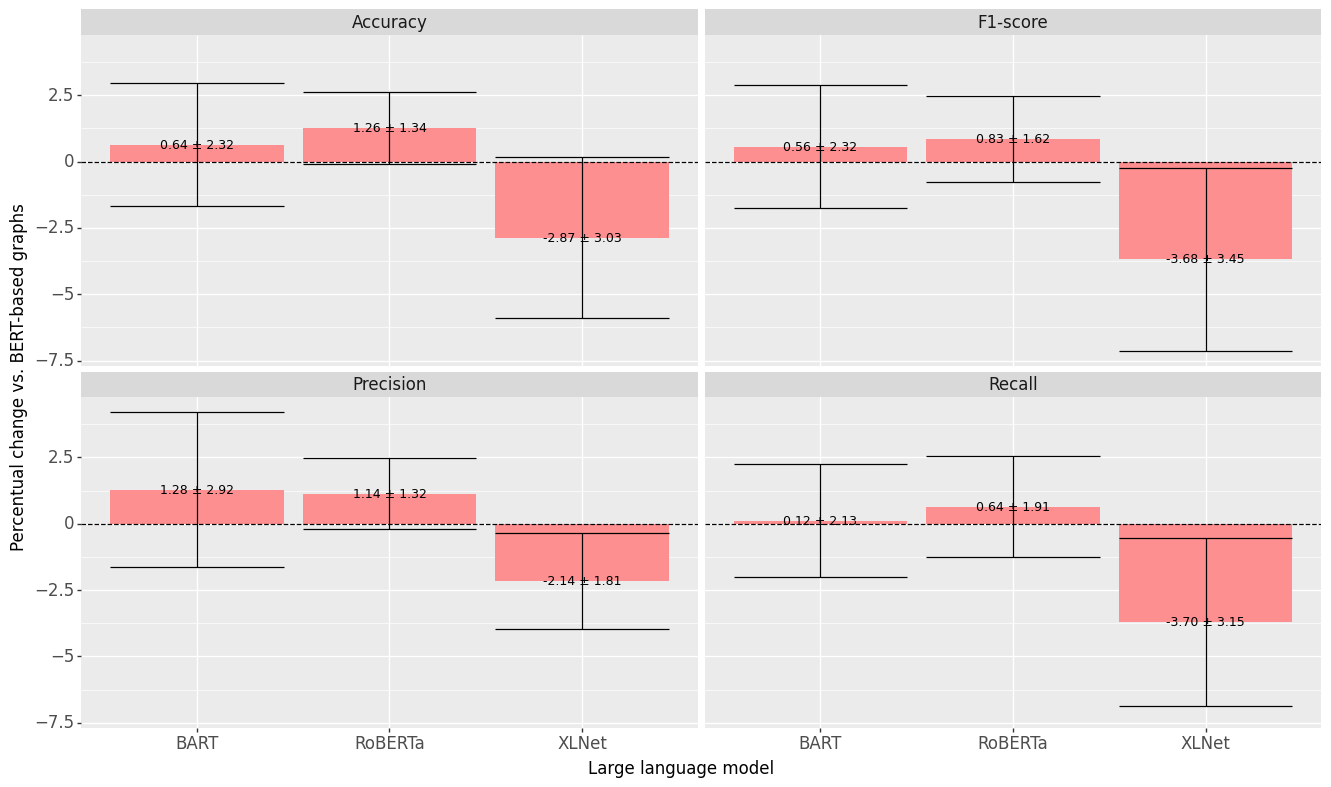

<ggplot: (401496926)>

In [51]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs. BERT-based graphs') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

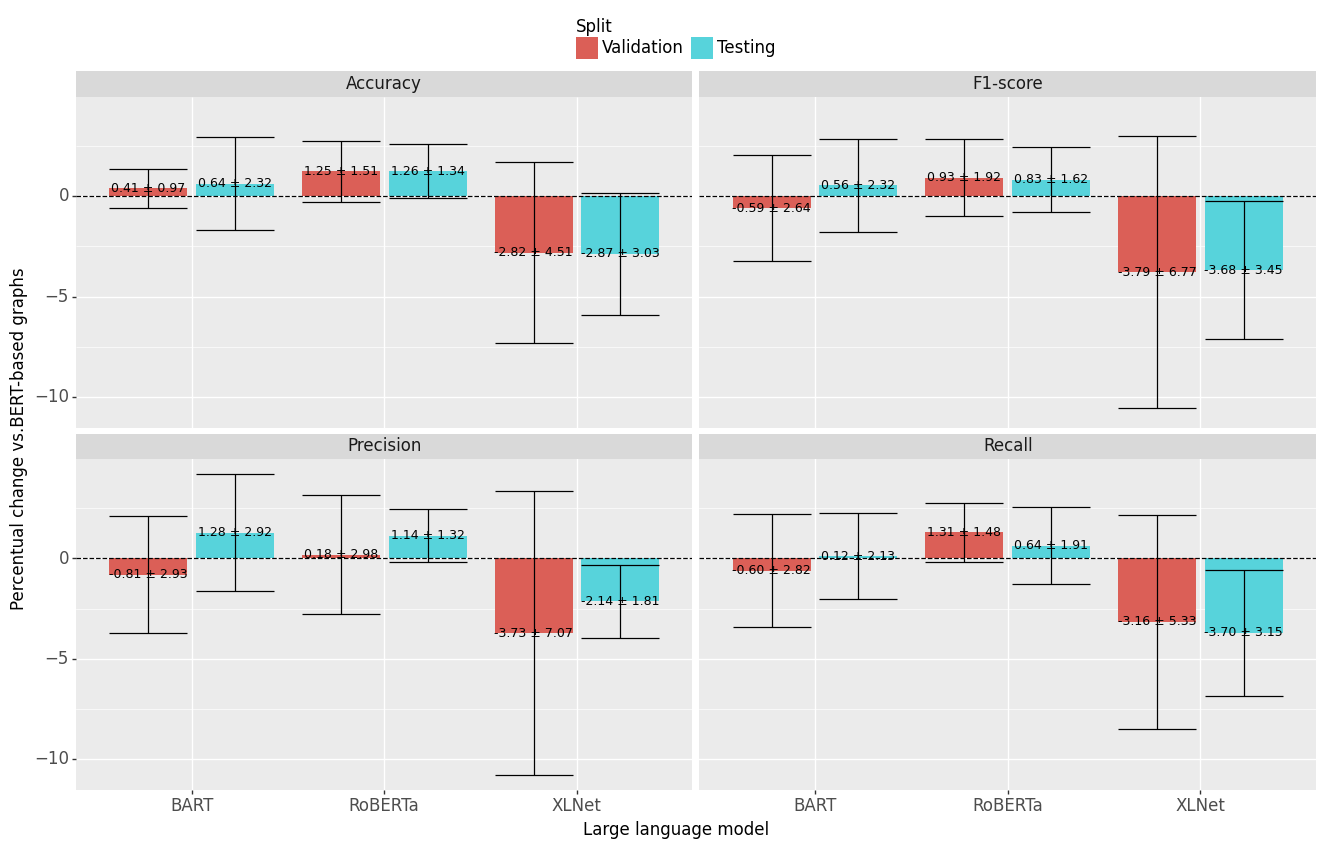

<ggplot: (401524547)>

In [52]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs.BERT-based graphs') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

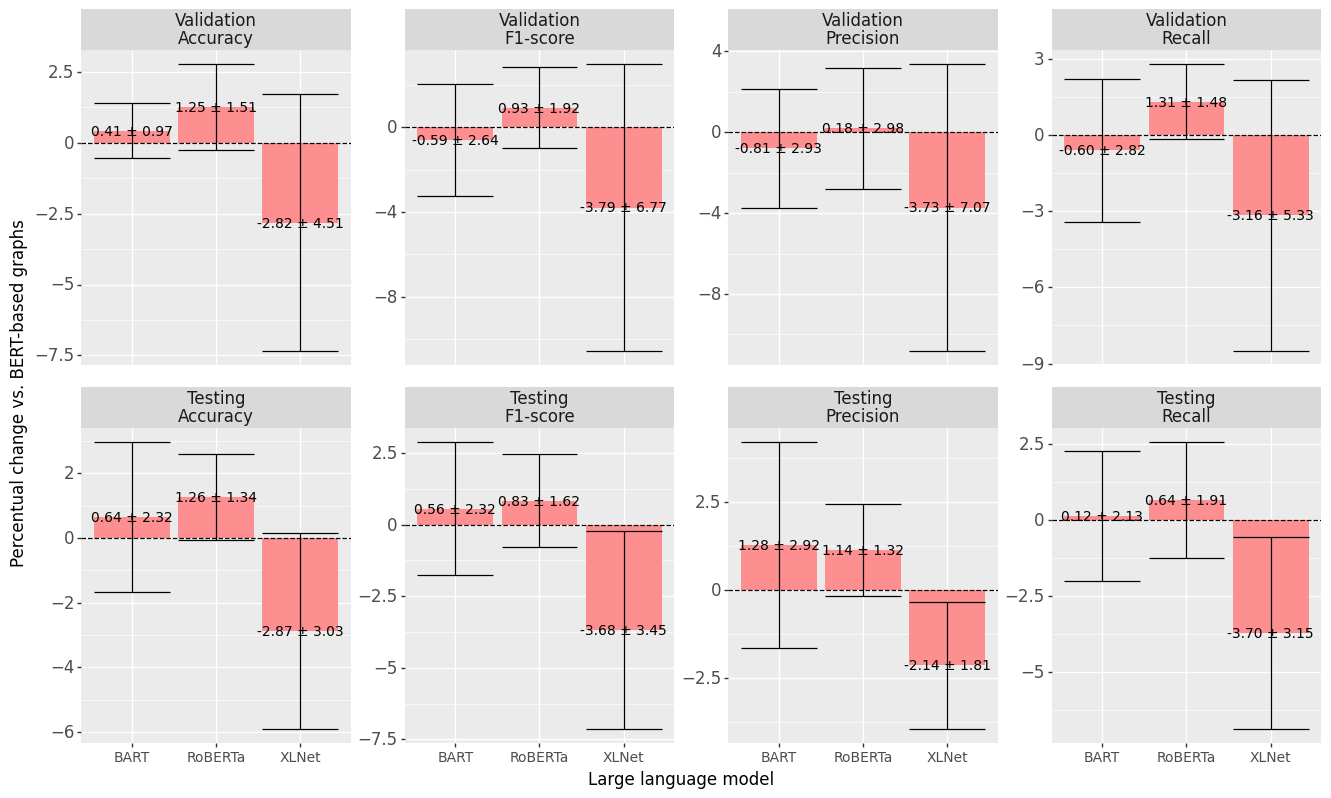

<ggplot: (400629688)>

In [53]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4, scales = 'free_y') + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs. BERT-based graphs') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12),
    axis_text_x = p9.element_text(size = 10),
    subplots_adjust = {
      'hspace': 0.2,
      'wspace': 0.2
    }
  )

# Statistical significance

In [54]:
def get_best_results_for_statistics(datasets, gnns, llms, methods, aggregations, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for llm in llms:
        for method in methods:
          for aggregation in aggregations:
            df = load_performance_metrics(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
            # 'trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'
            df = remove_trials_with_exceptions(df)
            
            df_aggregated = df.groupby(['trial', 'split']).agg({
              'accuracy' : ['mean', 'std'],
              'f1_score' : ['mean', 'std'],
              'precision' : ['mean', 'std'],
              'recall' : ['mean', 'std'],
            }).reset_index()
            df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
            
            best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']
            best_trial = df[df['trial'] == best_trial_number]
            best_trial['target_metric'] = best_trial[target_metric]
            best_trial.drop(columns = ['accuracy', 'f1_score', 'precision', 'recall'], inplace = True)
            best_trial['dataset'] = dataset
            best_trial['gnn'] = gnn
            best_trial['method'] = method
            best_trial['aggregation'] = aggregation
            best_trial['llm'] = llm
            results.append(best_trial)

  return pd.concat(results, axis = 0)

In [55]:
stats_df = get_best_results_for_statistics(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llms = ['google-bert-bert-base-uncased', 'facebook-bart-base', 'FacebookAI-roberta-base', 'xlnet-xlnet-base-cased'],
  methods = ['Grouped'],
  aggregations = ['No_Aggregation']
)

In [56]:
stats_df

,trial,random_state,split,target_metric,dataset,gnn,method,aggregation,llm
0,221,42,validation,0.907110,SST-2,GATv2,Grouped,No_Aggregation,google-bert-bert-base-uncased
1,221,42,test,0.891818,SST-2,GATv2,Grouped,No_Aggregation,google-bert-bert-base-uncased
2,221,45,validation,0.902523,SST-2,GATv2,Grouped,No_Aggregation,google-bert-bert-base-uncased
3,221,45,test,0.897309,SST-2,GATv2,Grouped,No_Aggregation,google-bert-bert-base-uncased
4,221,44,validation,0.902523,SST-2,GATv2,Grouped,No_Aggregation,google-bert-bert-base-uncased
...,...,...,...,...,...,...,...,...,...
15,371,46,test,0.901493,IMDb-top_1000,GATv2,Grouped,No_Aggregation,xlnet-xlnet-base-cased
16,371,41,validation,0.903030,IMDb-top_1000,GATv2,Grouped,No_Aggregation,xlnet-xlnet-base-cased
17,371,41,test,0.922388,IMDb-top_1000,GATv2,Grouped,No_Aggregation,xlnet-xlnet-base-cased
18,371,40,validation,0.933333,IMDb-top_1000,GATv2,Grouped,No_Aggregation,xlnet-xlnet-base-cased


In [57]:
# Based on https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/
for i, split in enumerate(['validation', 'test']):
  print(split)
  split_df = stats_df[(stats_df['split'] == split)].drop(columns = ['trial', 'split', 'gnn', 'method', 'aggregation']) \
    .pivot(index = ['dataset', 'random_state'], columns = 'llm', values = 'target_metric') \
    .reset_index() \
    .sort_values(by = ['dataset', 'random_state'])
  
  for (x, y) in itertools.combinations(['google-bert-bert-base-uncased', 'facebook-bart-base', 'FacebookAI-roberta-base', 'xlnet-xlnet-base-cased'], 2):
    # H0: Mean Grouped and Surrogate scores are equal
    # H1: Mean Grouped and Surrogate scores are not equal
    statistic, p_value = stats.ttest_rel(split_df[x], split_df[y])
    # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
    print(f'{x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

validation
google-bert-bert-base-uncased - facebook-bart-base: Statistic: 0.7681589674414336 P-value: 0.4470192489615272 Reject H0? False
google-bert-bert-base-uncased - FacebookAI-roberta-base: Statistic: -3.439934452588692 P-value: 0.0014000094450605132 Reject H0? True
google-bert-bert-base-uncased - xlnet-xlnet-base-cased: Statistic: 3.276299962509786 P-value: 0.0022131835743884366 Reject H0? True
facebook-bart-base - FacebookAI-roberta-base: Statistic: -5.358280355027521 P-value: 4.021711183751279e-06 Reject H0? True
facebook-bart-base - xlnet-xlnet-base-cased: Statistic: 3.7720796091937077 P-value: 0.0005377921275358141 Reject H0? True
FacebookAI-roberta-base - xlnet-xlnet-base-cased: Statistic: 5.229885844809724 P-value: 6.048939043047009e-06 Reject H0? True

test
google-bert-bert-base-uncased - facebook-bart-base: Statistic: -1.0359734933839504 P-value: 0.30659561649852657 Reject H0? False
google-bert-bert-base-uncased - FacebookAI-roberta-base: Statistic: -2.8978543755565638 P-

# Large LLMs

## SST-2

In [58]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     111
value                                 0.952982
params_attention_heads                       7
params_attention_pooling_operation         min
params_balanced_loss                     False
params_batch_size                          188
params_beta_0                         0.833149
params_beta_1                         0.994217
params_dropout_rate                   0.569644
params_early_stopping_patience              13
params_embedding_pooling_operation        mean
params_epochs                               73
params_epsilon                             0.0
params_global_pooling                      max
params_hidden_dimension                     49
params_learning_rate                  0.001239
params_number_of_hidden_layers               3
params_plateau_divider                       4
params_plateau_patience                     20
params_threshold                      0.603626
params_weight_decay                   0.000005
user_attrs_ep

In [59]:
get_best_results(dataset = 'SST-2', gnn = 'GATv2', llm = 'FacebookAI-roberta-large', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                      64
value                                 0.938073
params_attention_heads                      13
params_attention_pooling_operation         max
params_balanced_loss                      True
params_batch_size                          148
params_beta_0                         0.858116
params_beta_1                           0.9938
params_dropout_rate                   0.501638
params_early_stopping_patience              24
params_embedding_pooling_operation         min
params_epochs                              137
params_epsilon                        0.000001
params_global_pooling                     mean
params_hidden_dimension                    101
params_learning_rate                  0.001318
params_number_of_hidden_layers               2
params_plateau_divider                       7
params_plateau_patience                     21
params_threshold                      0.855918
params_weight_decay                   0.000004
user_attrs_ep

## R8

In [109]:
def get_best_results_with_exceptions(dataset, gnn, llm, method, aggregation, target_metric):
  df = load_performance_metrics_with_exceptions(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation, display_information = True)
  df = remove_trials_with_exceptions(df)
  df_aggregated = df.groupby(['trial', 'split']).agg({
    'accuracy' : ['mean', 'std'],
    'f1_score' : ['mean', 'std'],
    'precision' : ['mean', 'std'],
    'recall' : ['mean', 'std'],
  }).reset_index()
  df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
  
  best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

  best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

  print(best_trial_number)
  print('-' * 10, 'Validation', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'validation']['recall_std'].values[0] * 100, decimals = 2))
  )

  print('-' * 10, 'Test', '-' * 10)

  print(
    'Accuracy:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_mean'].values[0] * 100, decimals = 2)),
    '±', 
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['accuracy_std'].values[0] * 100, decimals = 2))
  )
  print(
    'F1-score:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['f1_score_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Precision:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['precision_std'].values[0] * 100, decimals = 2))
  )
  print(
    'Recall:',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_mean'].values[0] * 100, decimals = 2)),
    '±',
    '{:.2f}'.format(np.round(best_trial[best_trial['split'] == 'test']['recall_std'].values[0] * 100, decimals = 2))
  )


In [110]:
get_best_results_with_exceptions(dataset = 'R8', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     255
value                                 0.980578
params_attention_heads                      16
params_attention_pooling_operation        mean
params_balanced_loss                      True
params_batch_size                           54
params_beta_0                         0.885474
params_beta_1                         0.983331
params_dropout_rate                   0.575229
params_early_stopping_patience              20
params_embedding_pooling_operation         max
params_epochs                              144
params_epsilon                        0.000001
params_global_pooling                      max
params_hidden_dimension                     77
params_learning_rate                  0.000019
params_left_stride                          64
params_number_of_hidden_layers               3
params_plateau_divider                       7
params_plateau_patience                     19
params_right_stride                        128
params_thresh

In [63]:
get_best_results(dataset = 'R8', gnn = 'GATv2', llm = 'FacebookAI-roberta-large', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     176
value                                 0.970023
params_attention_heads                       4
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                          156
params_beta_0                         0.865683
params_beta_1                         0.991509
params_dropout_rate                   0.527537
params_early_stopping_patience              16
params_embedding_pooling_operation         max
params_epochs                              198
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                    248
params_learning_rate                  0.000936
params_left_stride                         256
params_number_of_hidden_layers               0
params_plateau_divider                       6
params_plateau_patience                     15
params_right_stride                        128
params_thresh

## Ohsumed

In [64]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     184
value                                 0.676073
params_attention_heads                       9
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           75
params_beta_0                         0.825653
params_beta_1                         0.989955
params_dropout_rate                   0.468633
params_early_stopping_patience              25
params_embedding_pooling_operation        mean
params_epochs                              133
params_epsilon                        0.000007
params_global_pooling                     mean
params_hidden_dimension                    241
params_learning_rate                  0.001416
params_left_stride                          64
params_number_of_hidden_layers               1
params_plateau_divider                       2
params_plateau_patience                     21
params_right_stride                         64
params_thresh

In [65]:
get_best_results(dataset = 'Ohsumed', gnn = 'GATv2', llm = 'FacebookAI-roberta-large', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'f1_score')

number                                     261
value                                 0.662537
params_attention_heads                      11
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           36
params_beta_0                         0.821725
params_beta_1                         0.997318
params_dropout_rate                   0.429354
params_early_stopping_patience              16
params_embedding_pooling_operation        mean
params_epochs                               70
params_epsilon                        0.000049
params_global_pooling                      max
params_hidden_dimension                    197
params_learning_rate                  0.000426
params_left_stride                          32
params_number_of_hidden_layers               1
params_plateau_divider                       9
params_plateau_patience                     11
params_right_stride                        256
params_thresh

## IMDb Top 1k

In [66]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'facebook-bart-large', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     273
value                                 0.963636
params_attention_heads                      16
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           60
params_beta_0                         0.874982
params_beta_1                         0.988088
params_dropout_rate                   0.534776
params_early_stopping_patience              16
params_embedding_pooling_operation        mean
params_epochs                              184
params_epsilon                             0.0
params_global_pooling                     mean
params_hidden_dimension                     66
params_learning_rate                   0.00186
params_left_stride                          64
params_number_of_hidden_layers               1
params_plateau_divider                       3
params_plateau_patience                     21
params_right_stride                         64
params_thresh

In [67]:
get_best_results(dataset = 'IMDb-top_1000', gnn = 'GATv2', llm = 'FacebookAI-roberta-large', method = 'Grouped', aggregation = 'No_Aggregation', target_metric = 'accuracy')

number                                     250
value                                 0.969697
params_attention_heads                       4
params_attention_pooling_operation         max
params_balanced_loss                     False
params_batch_size                           19
params_beta_0                         0.812378
params_beta_1                         0.994123
params_dropout_rate                   0.493444
params_early_stopping_patience              20
params_embedding_pooling_operation         max
params_epochs                              186
params_epsilon                        0.000001
params_global_pooling                     mean
params_hidden_dimension                     43
params_learning_rate                  0.007994
params_left_stride                           0
params_number_of_hidden_layers               1
params_plateau_divider                       3
params_plateau_patience                     17
params_right_stride                        256
params_thresh

### Visual analysis

In [68]:
def load_performance_metrics_with_exceptions(dataset, gnn, llm, method, aggregation, display_information = False):
  
  study_name = f'{dataset}-{gnn}-{llm.replace("/", "-")}-{method}-{aggregation}'
  storage = f'sqlite:///../../pipelines/optuna_studies/{study_name}.db'
  study = optuna.load_study(study_name = study_name, storage = storage)
  
  study_df = study.trials_dataframe()

  study_df = study_df[study_df['value'] >= 0.0].sort_values(by = 'number', ascending = True)
  columns = ['number', 'value'] + [x for x in study_df.columns if x.startswith('params_')] + [x for x in study_df.columns if x.startswith('user_attrs_')]

  top_trials = study_df[columns].head(TRIALS).sort_values(by = ['value', 'user_attrs_validation_loss', 'user_attrs_training_loss'], ascending = [False, True, True]).head(5) # .head(3) for R8, BART-large due to exceptions
  
  performance = list()
  #for trial in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{x}')]:
  for _, row in top_trials.iterrows():
    
    if display_information:
      print(row)
    trial = row['number']

    if len([x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]) != 10:
      continue

    for random_state in [x for x in os.listdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}') if os.path.isdir(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{x}')]:
      df = pd.read_csv(f'../../outputs/{dataset}-{gnn}-{llm}/{method}/{aggregation}/{trial}/{random_state}/predictions.csv')
      for split in ['validation', 'test']:
        df_split = df[df['split'] == split]
        accuracy = sklearn.metrics.accuracy_score(df_split['real'], df_split['prediction'])
        f1_score = sklearn.metrics.f1_score(df_split['real'], df_split['prediction'], average = 'macro')
        precision = sklearn.metrics.precision_score(df_split['real'], df_split['prediction'], average = 'macro')
        recall = sklearn.metrics.recall_score(df_split['real'], df_split['prediction'], average = 'macro')
        performance.append((trial, random_state, split, accuracy, f1_score, precision, recall))
    break
  return pd.DataFrame(performance, columns = ['trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'])

In [69]:
def get_best_results_for_plot_with_exceptions(datasets, gnns, llms, methods, aggregations, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for llm in llms:
        for method in methods:
          for aggregation in aggregations:
            df = load_performance_metrics_with_exceptions(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
            df = remove_trials_with_exceptions(df)
            df_aggregated = df.groupby(['trial', 'split']).agg({
              'accuracy' : ['mean', 'std'],
              'f1_score' : ['mean', 'std'],
              'precision' : ['mean', 'std'],
              'recall' : ['mean', 'std'],
            }).reset_index()
            df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
            
            best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']

            best_trial = df_aggregated[df_aggregated['trial'] == best_trial_number]

            best_trial_validation = best_trial[best_trial['split'] == 'validation']
            best_trial_test = best_trial[best_trial['split'] == 'test']

            results.append((dataset, target_metric, gnn, llm, method, aggregation, best_trial_validation['accuracy_mean'].values[0], best_trial_validation['accuracy_std'].values[0], \
              best_trial_validation['f1_score_mean'].values[0], best_trial_validation['f1_score_std'].values[0], \
              best_trial_validation['precision_mean'].values[0], best_trial_validation['precision_std'].values[0], \
              best_trial_validation['recall_mean'].values[0], best_trial_validation['recall_std'].values[0], \
              best_trial_test['accuracy_mean'].values[0], best_trial_test['accuracy_std'].values[0], \
              best_trial_test['f1_score_mean'].values[0], best_trial_test['f1_score_std'].values[0], \
              best_trial_test['precision_mean'].values[0], best_trial_test['precision_std'].values[0], \
              best_trial_test['recall_mean'].values[0], best_trial_test['recall_std'].values[0]))
  return pd.DataFrame(
    results,
    columns = ['dataset', 'target_metric', 'gnn', 'llm', 'method', 'aggregation', 'validation_accuracy_mean', 'validation_accuracy_std', 'validation_f1_score_mean', 'validation_f1_score_std', \
              'validation_precision_mean', 'validation_precision_std', 'validation_recall_mean', 'validation_recall_std', 'test_accuracy_mean', 'test_accuracy_std', \
              'test_f1_score_mean', 'test_f1_score_std', 'test_precision_mean', 'test_precision_std', 'test_recall_mean', 'test_recall_std']
  )

In [70]:
best_results_df = get_best_results_for_plot_with_exceptions(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llms = ['facebook-bart-base', 'facebook-bart-large', 'FacebookAI-roberta-base', 'FacebookAI-roberta-large'],
  methods = ['Grouped'],
  aggregations = ['No_Aggregation']
)

In [71]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.915596,0.004194,0.915550,0.004214,...,0.915606,0.004247,0.918561,0.005184,0.918523,0.005202,0.919382,0.005026,0.918582,0.005190
1,SST-2,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.946789,0.002037,0.946756,0.002048,...,0.946678,0.002109,0.946952,0.003859,0.946937,0.003870,0.947501,0.003491,0.946978,0.003846
2,SST-2,accuracy,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.921216,0.003060,0.921201,0.003066,...,0.921536,0.003134,0.922680,0.002269,0.922662,0.002278,0.923042,0.002148,0.922669,0.002271
3,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.928670,0.002746,0.928633,0.002763,...,0.928633,0.002817,0.930313,0.004047,0.930298,0.004060,0.930692,0.003762,0.930321,0.004038
4,R8,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.979945,0.001664,0.950488,0.005558,...,0.956030,0.007546,0.977798,0.002271,0.943850,0.006065,0.952309,0.006760,0.936925,0.005840
5,R8,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.979216,0.004378,0.968748,0.006355,...,0.975923,0.004842,0.973869,0.001609,0.935613,0.005305,0.937110,0.008225,0.935968,0.004135
6,R8,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.980492,0.001675,0.951333,0.005582,...,0.963495,0.005226,0.977524,0.001094,0.939366,0.005070,0.951990,0.005807,0.929869,0.004254
7,R8,f1_score,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.980675,0.002096,0.957052,0.007765,...,0.960559,0.011416,0.976884,0.002068,0.935743,0.006011,0.951308,0.005953,0.925456,0.007325
8,Ohsumed,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.709673,0.006174,0.608981,0.013366,...,0.604547,0.015281,0.716003,0.007080,0.627257,0.010538,0.649748,0.012749,0.622424,0.009265
9,Ohsumed,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.744345,0.013343,0.660718,0.015217,...,0.671941,0.019761,0.735518,0.006111,0.663227,0.006845,0.669634,0.008828,0.671270,0.012231


## Rank analysis

In [72]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_rank'] = best_results_df[['dataset', column]].groupby(['dataset']).rank(method = 'max', ascending = False)

In [73]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,test_recall_mean,test_recall_std,validation_accuracy_mean_rank,validation_f1_score_mean_rank,validation_precision_mean_rank,validation_recall_mean_rank,test_accuracy_mean_rank,test_f1_score_mean_rank,test_precision_mean_rank,test_recall_mean_rank
0,SST-2,accuracy,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.915596,0.004194,0.915550,0.004214,...,0.918582,0.005190,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,SST-2,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.946789,0.002037,0.946756,0.002048,...,0.946978,0.003846,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,SST-2,accuracy,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.921216,0.003060,0.921201,0.003066,...,0.922669,0.002271,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.928670,0.002746,0.928633,0.002763,...,0.930321,0.004038,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,R8,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.979945,0.001664,0.950488,0.005558,...,0.936925,0.005840,3.0,4.0,3.0,4.0,1.0,1.0,1.0,1.0
5,R8,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.979216,0.004378,0.968748,0.006355,...,0.935968,0.004135,4.0,1.0,1.0,1.0,4.0,4.0,4.0,2.0
6,R8,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.980492,0.001675,0.951333,0.005582,...,0.929869,0.004254,2.0,3.0,4.0,2.0,2.0,2.0,2.0,3.0
7,R8,f1_score,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.980675,0.002096,0.957052,0.007765,...,0.925456,0.007325,1.0,2.0,2.0,3.0,3.0,3.0,3.0,4.0
8,Ohsumed,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.709673,0.006174,0.608981,0.013366,...,0.622424,0.009265,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0
9,Ohsumed,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.744345,0.013343,0.660718,0.015217,...,0.671270,0.012231,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0


In [74]:
best_results_df_grouped = best_results_df.groupby(['llm']).agg({
  'validation_accuracy_mean_rank' : ['mean', 'std'],
  'test_accuracy_mean_rank' : ['mean', 'std'],
  'validation_f1_score_mean_rank' : ['mean', 'std'],
  'test_f1_score_mean_rank' : ['mean', 'std'],
  'validation_precision_mean_rank' : ['mean', 'std'],
  'test_precision_mean_rank' : ['mean', 'std'],
  'validation_recall_mean_rank' : ['mean', 'std'],
  'test_recall_mean_rank' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [75]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['llm'], var_name = 'information', value_name = 'value') # .drop(columns = ['gnn', 'method'])
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [76]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['llm', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [77]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [78]:
best_results_df_grouped.head()

mean_std,llm,split,metric,mean,std,label
0,FacebookAI-roberta-base,test,accuracy,3.00,0.816497,3.00 ± 0.82
1,FacebookAI-roberta-base,test,f1,3.00,0.816497,3.00 ± 0.82
2,FacebookAI-roberta-base,test,precision,3.00,0.816497,3.00 ± 0.82
3,FacebookAI-roberta-base,test,recall,3.25,0.500000,3.25 ± 0.50
4,FacebookAI-roberta-base,validation,accuracy,2.75,0.500000,2.75 ± 0.50


In [79]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()

In [80]:
best_results_df_grouped['llm'] = best_results_df_grouped['llm'].replace({
  'FacebookAI-roberta-base' : 'RoBERTa',
  'facebook-bart-base' : 'BART',
  'FacebookAI-roberta-large' : 'RoBERTa-L',
  'facebook-bart-large' : 'BART-L'
})

In [81]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

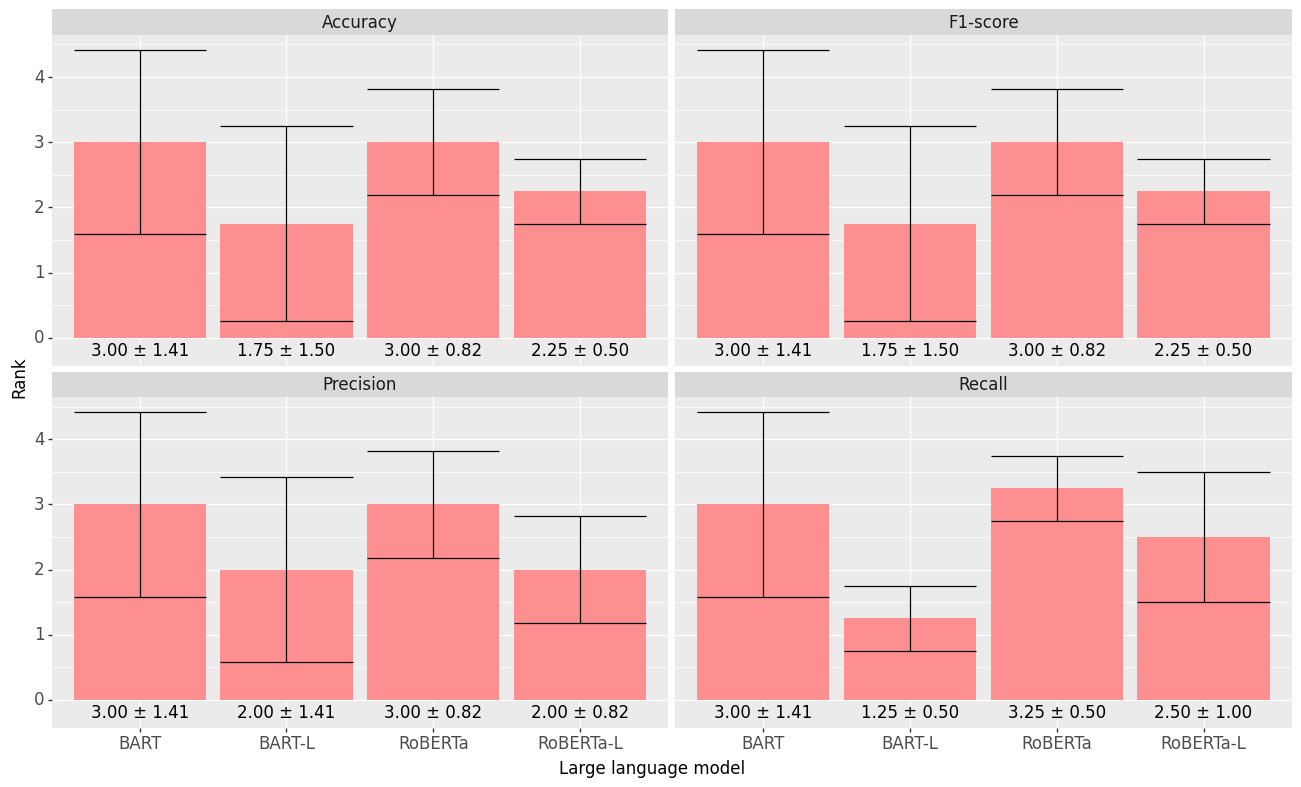

<ggplot: (806542559)>

In [82]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.2, label = 'label'), position = p9.position_dodge2(width = .9), size = 12) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

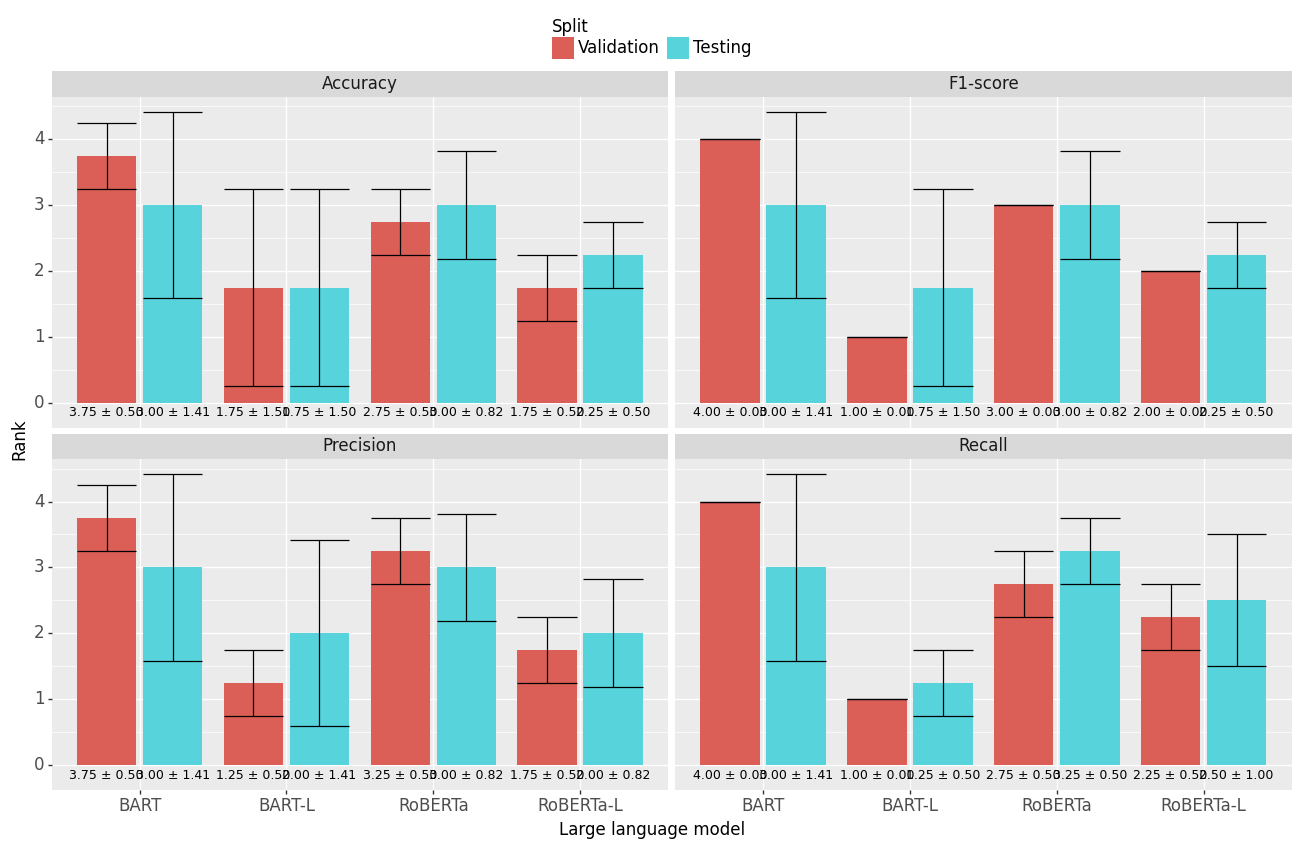

<ggplot: (401117818)>

In [83]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Rank') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

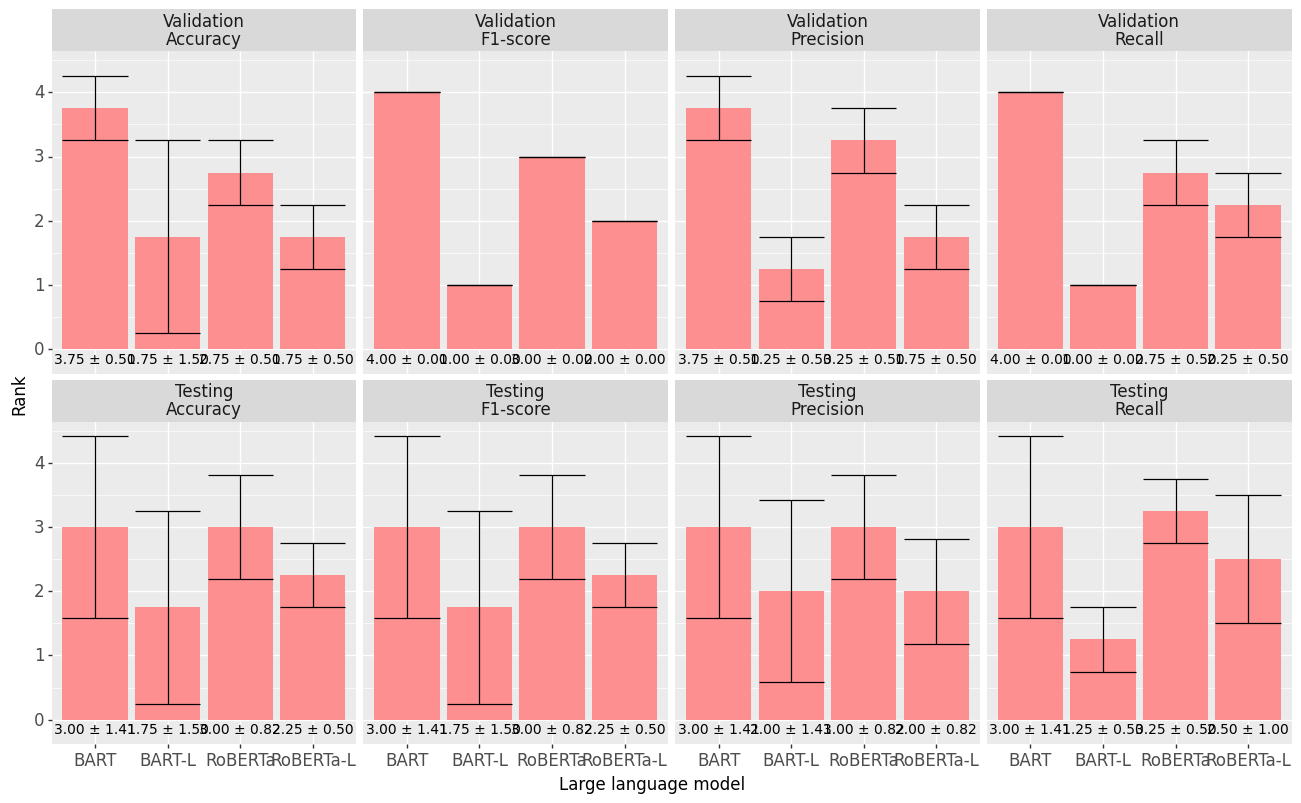

<ggplot: (401758467)>

In [84]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(y = -0.15, label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4) + \
  p9.xlab('Large language model') + \
  p9.ylab('Rank') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

## Percentage change analysis

In [85]:
best_results_df.drop(columns = [x for x in best_results_df.columns if x.endswith('_rank')], inplace = True)

In [86]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,validation_recall_mean,validation_recall_std,test_accuracy_mean,test_accuracy_std,test_f1_score_mean,test_f1_score_std,test_precision_mean,test_precision_std,test_recall_mean,test_recall_std
0,SST-2,accuracy,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.915596,0.004194,0.915550,0.004214,...,0.915606,0.004247,0.918561,0.005184,0.918523,0.005202,0.919382,0.005026,0.918582,0.005190
1,SST-2,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.946789,0.002037,0.946756,0.002048,...,0.946678,0.002109,0.946952,0.003859,0.946937,0.003870,0.947501,0.003491,0.946978,0.003846
2,SST-2,accuracy,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.921216,0.003060,0.921201,0.003066,...,0.921536,0.003134,0.922680,0.002269,0.922662,0.002278,0.923042,0.002148,0.922669,0.002271
3,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.928670,0.002746,0.928633,0.002763,...,0.928633,0.002817,0.930313,0.004047,0.930298,0.004060,0.930692,0.003762,0.930321,0.004038
4,R8,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.979945,0.001664,0.950488,0.005558,...,0.956030,0.007546,0.977798,0.002271,0.943850,0.006065,0.952309,0.006760,0.936925,0.005840
5,R8,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.979216,0.004378,0.968748,0.006355,...,0.975923,0.004842,0.973869,0.001609,0.935613,0.005305,0.937110,0.008225,0.935968,0.004135
6,R8,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.980492,0.001675,0.951333,0.005582,...,0.963495,0.005226,0.977524,0.001094,0.939366,0.005070,0.951990,0.005807,0.929869,0.004254
7,R8,f1_score,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.980675,0.002096,0.957052,0.007765,...,0.960559,0.011416,0.976884,0.002068,0.935743,0.006011,0.951308,0.005953,0.925456,0.007325
8,Ohsumed,f1_score,GATv2,facebook-bart-base,Grouped,No_Aggregation,0.709673,0.006174,0.608981,0.013366,...,0.604547,0.015281,0.716003,0.007080,0.627257,0.010538,0.649748,0.012749,0.622424,0.009265
9,Ohsumed,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.744345,0.013343,0.660718,0.015217,...,0.671941,0.019761,0.735518,0.006111,0.663227,0.006845,0.669634,0.008828,0.671270,0.012231


In [87]:
best_results_df['is_base'] = (best_results_df['gnn'] == 'GATv2') & (best_results_df['method'] == 'Grouped') & (best_results_df['aggregation'] == 'No_Aggregation') & (best_results_df['llm'] == 'facebook-bart-base')

In [88]:
for column in [x for x in best_results_df.columns if x.endswith('_mean')]:
  best_results_df[f'{column}_change'] = best_results_df[['dataset', column, 'is_base']] \
    .groupby(['dataset']) \
    .apply(
      lambda group: group.apply(
        lambda row: ((row[column] - group.loc[group['is_base'], column].values[0]) / group.loc[group['is_base'], column].values[0]) * 100
          if group['is_base'].any() else None, axis = 1
        )
    ).reset_index(drop = True)

In [89]:
best_results_df = best_results_df[~best_results_df['is_base']]

In [90]:
best_results_df

,dataset,target_metric,gnn,llm,method,aggregation,validation_accuracy_mean,validation_accuracy_std,validation_f1_score_mean,validation_f1_score_std,...,test_recall_std,is_base,validation_accuracy_mean_change,validation_f1_score_mean_change,validation_precision_mean_change,validation_recall_mean_change,test_accuracy_mean_change,test_f1_score_mean_change,test_precision_mean_change,test_recall_mean_change
1,SST-2,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.946789,0.002037,0.946756,0.002048,...,0.003846,False,3.691496,3.681173,3.797882,3.457705,5.962239,5.978477,5.859631,5.883988
2,SST-2,accuracy,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.921216,0.003060,0.921201,0.003066,...,0.002271,False,2.109426,2.080538,2.298668,1.825880,3.146737,3.153932,3.038042,3.078554
3,SST-2,accuracy,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.928670,0.002746,0.928633,0.002763,...,0.004038,False,2.373105,2.357920,2.502827,2.196348,3.908579,3.923864,3.845840,3.900295
5,R8,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.979216,0.004378,0.968748,0.006355,...,0.004135,False,4.885720,8.495658,5.239013,11.147775,2.725577,5.734525,3.060491,7.847786
6,R8,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.980492,0.001675,0.951333,0.005582,...,0.004254,False,0.545188,3.407583,1.569652,4.587812,-0.981070,-1.918577,-3.741621,-0.615837
7,R8,f1_score,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.980675,0.002096,0.957052,0.007765,...,0.007325,False,1.362969,5.537973,6.237886,6.464608,0.397264,3.378512,3.250542,4.252537
9,Ohsumed,f1_score,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.744345,0.013343,0.660718,0.015217,...,0.012231,False,-0.074419,1.921114,1.747145,2.080831,-0.401794,-0.872693,-1.595995,-0.102132
10,Ohsumed,f1_score,GATv2,FacebookAI-roberta-base,Grouped,No_Aggregation,0.713542,0.005579,0.629733,0.005021,...,0.012965,False,0.055814,0.088940,-0.480763,0.780816,-0.028032,-0.475118,-0.033536,-0.753058
11,Ohsumed,f1_score,GATv2,FacebookAI-roberta-large,Grouped,No_Aggregation,0.719345,0.010362,0.642706,0.004957,...,0.017869,False,0.074419,0.690644,0.896492,0.473694,-0.093440,-0.858923,-0.105065,-1.224075
13,IMDb-top_1000,accuracy,GATv2,facebook-bart-large,Grouped,No_Aggregation,0.953333,0.004990,0.953006,0.005031,...,0.006370,False,3.406814,3.408477,3.383884,3.393672,3.090811,3.093471,3.058452,3.091273


In [91]:
best_results_df_melted = best_results_df.drop(columns = ['dataset', 'target_metric', 'gnn', 'method', 'aggregation']).melt(id_vars = ['llm'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_melted['information'].str.split('_')
best_results_df_melted['split'] = split_information_column.str[0]
best_results_df_melted['metric'] = split_information_column.str[1]
best_results_df_melted.drop(columns = ['information'], inplace = True)

In [92]:
best_results_df_melted['metric'] = best_results_df_melted['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_melted['llm'] = best_results_df_melted['llm'].replace({
  'FacebookAI-roberta-base' : 'RoBERTa',
  'facebook-bart-base' : 'BART',
  'FacebookAI-roberta-large' : 'RoBERTa-L',
  'facebook-bart-large' : 'BART-L'
})
best_results_df_melted['split'] = best_results_df_melted['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_melted['split'] = pd.Categorical(best_results_df_melted['split'], categories = ['Validation', 'Testing'])

In [93]:
best_results_df_melted['value'] = best_results_df_melted['value'].astype(float)

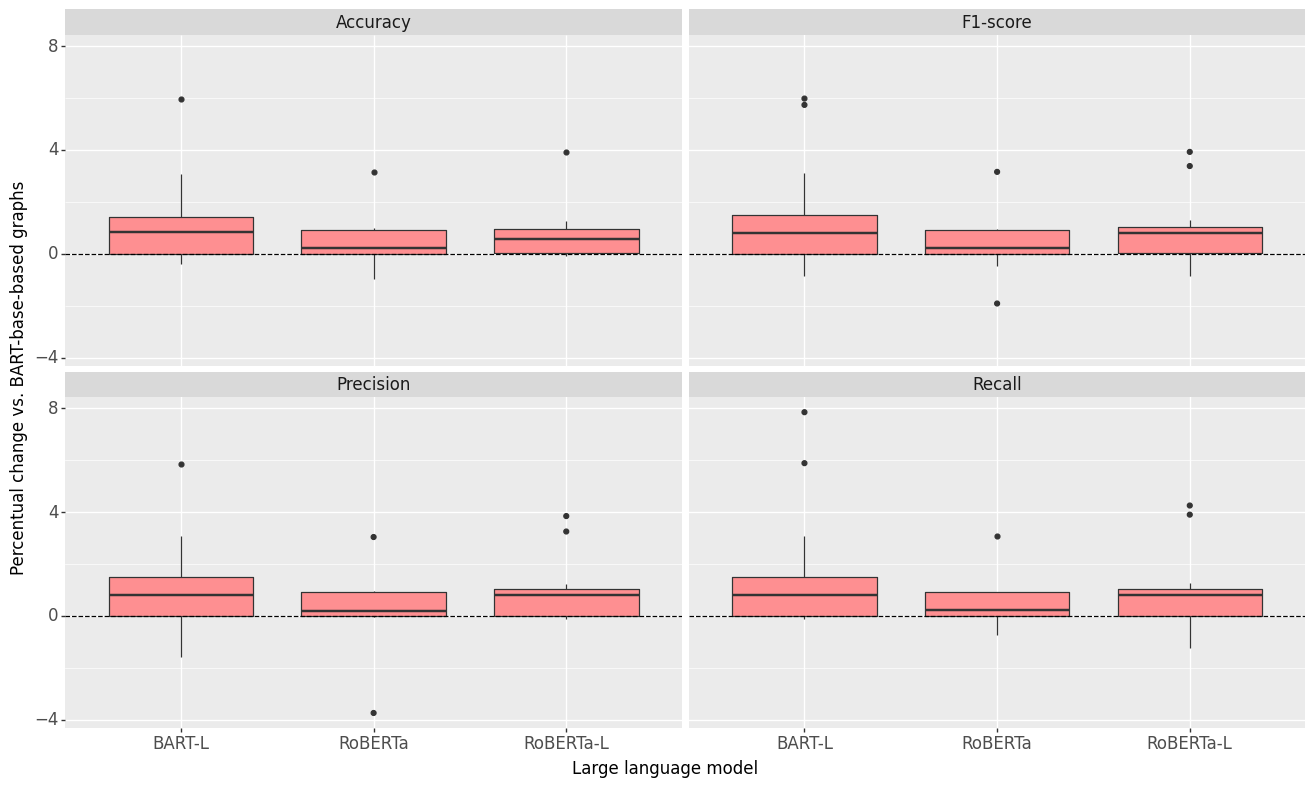

<ggplot: (401485137)>

In [94]:
p9.ggplot(best_results_df_melted[best_results_df_melted['split'] == 'Testing'],
  p9.aes(x = 'llm', y = 'value', group = 'llm')) + \
  p9.theme_gray() + \
  p9.geom_boxplot(fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs. BART-base-based graphs') + \
  p9.labs(fill = 'Graph neural network') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

In [95]:
best_results_df_grouped = best_results_df.groupby(['llm']).agg({
  'validation_accuracy_mean_change' : ['mean', 'std'],
  'test_accuracy_mean_change' : ['mean', 'std'],
  'validation_f1_score_mean_change' : ['mean', 'std'],
  'test_f1_score_mean_change' : ['mean', 'std'],
  'validation_precision_mean_change' : ['mean', 'std'],
  'test_precision_mean_change' : ['mean', 'std'],
  'validation_recall_mean_change' : ['mean', 'std'],
  'test_recall_mean_change' : ['mean', 'std'],
}).reset_index()
best_results_df_grouped.columns = best_results_df_grouped.columns.map('_'.join).str.strip('_')

In [96]:
best_results_df_grouped = best_results_df_grouped.melt(id_vars = ['llm'], var_name = 'information', value_name = 'value')
split_information_column = best_results_df_grouped['information'].str.split('_')
best_results_df_grouped['split'] = split_information_column.str[0]
best_results_df_grouped['metric'] = split_information_column.str[1]
best_results_df_grouped['mean_std'] = split_information_column.str[-1]
best_results_df_grouped.drop(columns = ['information'], inplace = True)

In [97]:
best_results_df_grouped = best_results_df_grouped.pivot_table(index = ['llm', 'split', 'metric'], columns = 'mean_std', values = 'value').reset_index()

In [98]:
best_results_df_grouped['label'] = best_results_df_grouped['mean'].map(lambda x : '{:.2f}'.format(x)) + ' ± ' + best_results_df_grouped['std'].map(lambda x : '{:.2f}'.format(x))

In [99]:
best_results_df_grouped.head()

mean_std,llm,split,metric,mean,std,label
0,FacebookAI-roberta-base,test,accuracy,0.646503,1.769597,0.65 ± 1.77
1,FacebookAI-roberta-base,test,f1,0.302702,2.136232,0.30 ± 2.14
2,FacebookAI-roberta-base,test,precision,-0.084754,2.790478,-0.08 ± 2.79
3,FacebookAI-roberta-base,test,recall,0.538657,1.775879,0.54 ± 1.78
4,FacebookAI-roberta-base,validation,accuracy,0.831039,0.887728,0.83 ± 0.89


In [100]:
best_results_df_grouped['metric'] = best_results_df_grouped['metric'].replace({'f1' : 'F1-score'}).str.capitalize()
best_results_df_grouped['llm'] = best_results_df_grouped['llm'].replace({
  'FacebookAI-roberta-base' : 'RoBERTa',
  'facebook-bart-base' : 'BART',
  'FacebookAI-roberta-large' : 'RoBERTa-L',
  'facebook-bart-large' : 'BART-L'
})

In [101]:
best_results_df_grouped['split'] = best_results_df_grouped['split'].replace({'test' : 'Testing'}).str.capitalize()
best_results_df_grouped['split'] = pd.Categorical(best_results_df_grouped['split'], categories = ['Validation', 'Testing'])

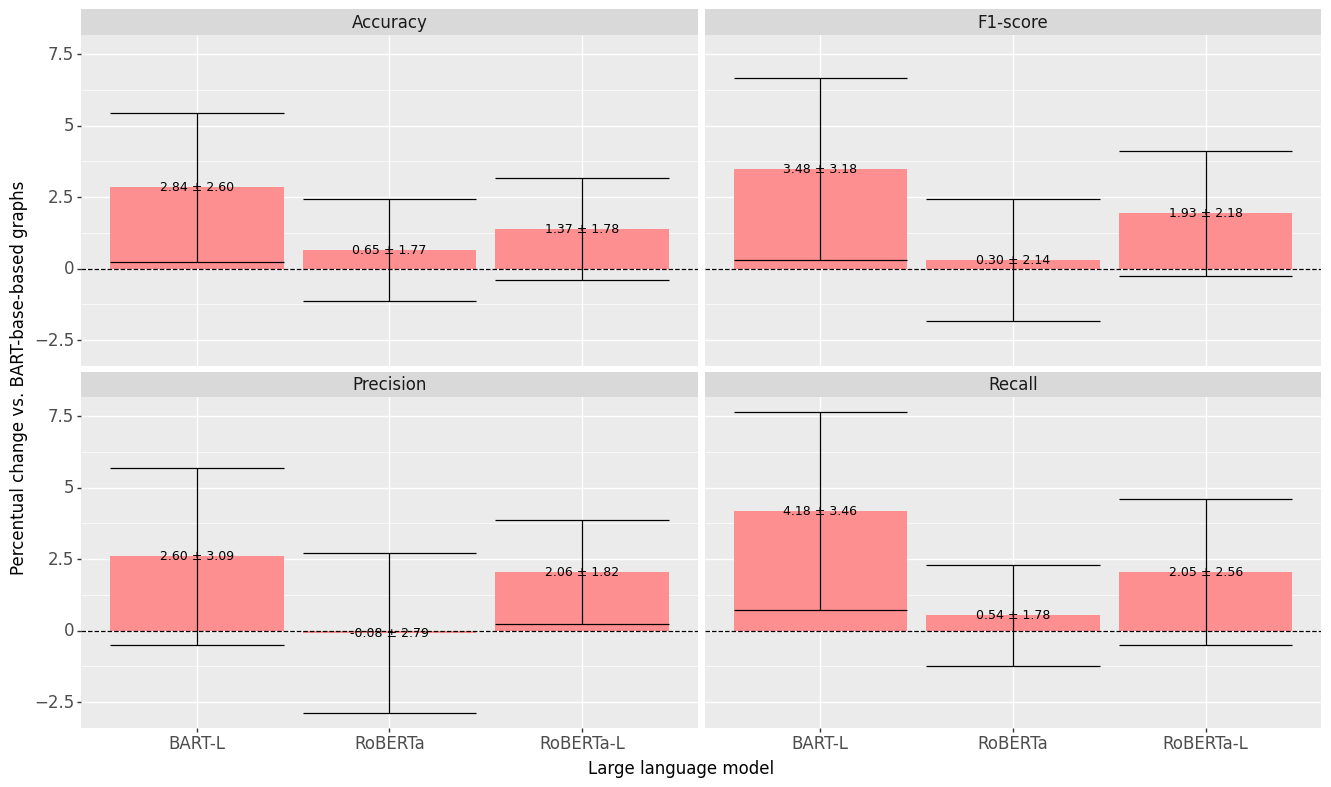

<ggplot: (806490275)>

In [102]:
p9.ggplot(best_results_df_grouped[best_results_df_grouped['split'] == 'Testing'],
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs. BART-base-based graphs') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

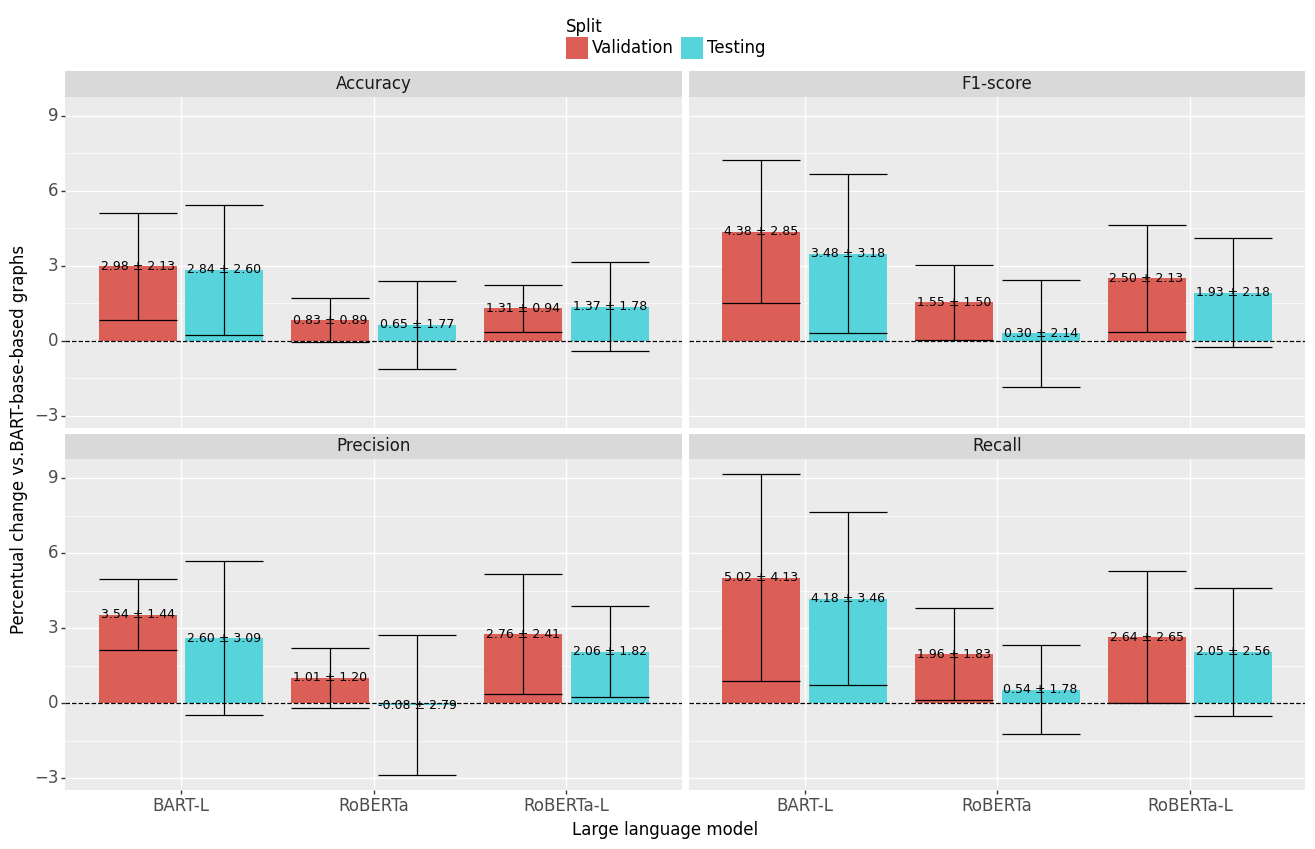

<ggplot: (400847134)>

In [103]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean', fill = 'split')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2()) + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 9) + \
  p9.facet_wrap('~metric', ncol = 2) + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs.BART-base-based graphs') + \
  p9.labs(fill = 'Split') + \
  p9.theme(
    legend_position = 'top',
    legend_box_margin = 0,
    figure_size = (16, 9),
    text = p9.element_text(size = 12)
  )

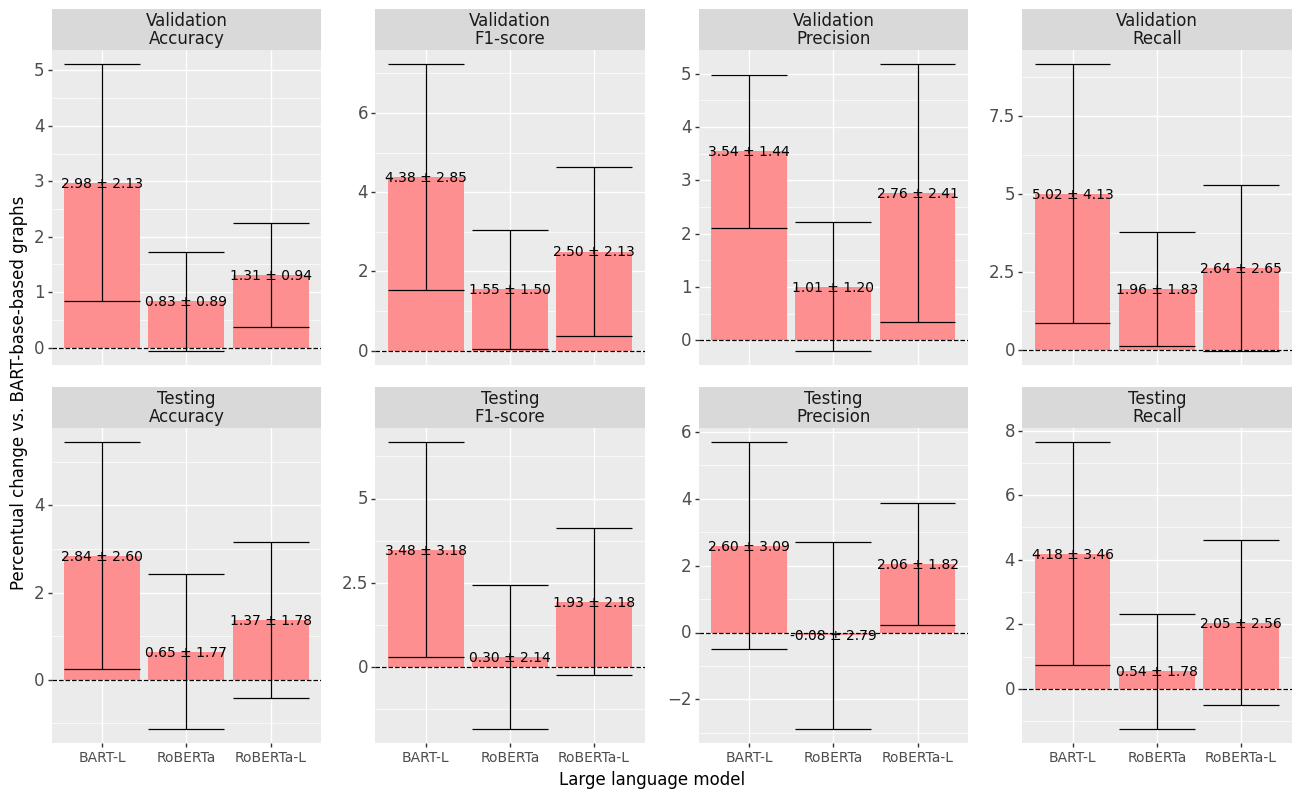

<ggplot: (402100182)>

In [104]:
p9.ggplot(best_results_df_grouped,
  p9.aes(x = 'llm', y = 'mean')) + \
  p9.theme_gray() + \
  p9.geom_bar(stat = 'identity', position = p9.position_dodge2(), fill = '#fe8f91') + \
  p9.geom_hline(yintercept = 0, linetype = 'dashed') + \
  p9.geom_errorbar(p9.aes(ymin = 'mean - std', ymax = 'mean + std'), position = p9.position_dodge2(), width = .9) + \
  p9.geom_text(p9.aes(label = 'label'), position = p9.position_dodge2(width = .9), size = 10) + \
  p9.facet_wrap('~split+metric', ncol = 4, scales = 'free_y') + \
  p9.xlab('Large language model') + \
  p9.ylab('Percentual change vs. BART-base-based graphs') + \
  p9.theme(
    legend_position = 'top',
    figure_size = (16, 9),
    text = p9.element_text(size = 12),
    axis_text_x = p9.element_text(size = 10),
    subplots_adjust = {
      'hspace': 0.2,
      'wspace': 0.2
    }
  )

# Statistical significance

In [105]:
def get_best_results_for_statistics_with_exceptions(datasets, gnns, llms, methods, aggregations, target_metrics):
  results = list()
  for dataset, target_metric in zip(datasets, target_metrics):
    for gnn in gnns:
      for llm in llms:
        for method in methods:
          for aggregation in aggregations:
            df = load_performance_metrics_with_exceptions(dataset = dataset, gnn = gnn, llm = llm, method = method, aggregation = aggregation)
            # 'trial', 'random_state', 'split', 'accuracy', 'f1_score', 'precision', 'recall'
            df = remove_trials_with_exceptions(df)
            
            df_aggregated = df.groupby(['trial', 'split']).agg({
              'accuracy' : ['mean', 'std'],
              'f1_score' : ['mean', 'std'],
              'precision' : ['mean', 'std'],
              'recall' : ['mean', 'std'],
            }).reset_index()
            df_aggregated.columns = df_aggregated.columns.map('_'.join).str.strip('_')
            
            best_trial_number = df_aggregated.sort_values(by = ['split', f'{target_metric}_mean', f'{target_metric}_std'], ascending = [True, False, True]).reset_index(drop = True).iloc[0]['trial']
            best_trial = df[df['trial'] == best_trial_number]
            best_trial['target_metric'] = best_trial[target_metric]
            best_trial.drop(columns = ['accuracy', 'f1_score', 'precision', 'recall'], inplace = True)
            best_trial['dataset'] = dataset
            best_trial['gnn'] = gnn
            best_trial['method'] = method
            best_trial['aggregation'] = aggregation
            best_trial['llm'] = llm
            results.append(best_trial)

  return pd.concat(results, axis = 0)

In [106]:
stats_df = get_best_results_for_statistics_with_exceptions(
  datasets = ['SST-2', 'R8', 'Ohsumed', 'IMDb-top_1000'],
  target_metrics = ['accuracy', 'f1_score', 'f1_score', 'accuracy'],
  gnns = ['GATv2'],
  llms = ['facebook-bart-base', 'facebook-bart-large', 'FacebookAI-roberta-base', 'FacebookAI-roberta-large'],
  methods = ['Grouped'],
  aggregations = ['No_Aggregation']
)

In [107]:
stats_df

,trial,random_state,split,target_metric,dataset,gnn,method,aggregation,llm
0,141,42,validation,0.910550,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-base
1,141,42,test,0.917079,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-base
2,141,45,validation,0.911697,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-base
3,141,45,test,0.914333,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-base
4,141,44,validation,0.915138,SST-2,GATv2,Grouped,No_Aggregation,facebook-bart-base
...,...,...,...,...,...,...,...,...,...
15,250,46,test,0.940299,IMDb-top_1000,GATv2,Grouped,No_Aggregation,FacebookAI-roberta-large
16,250,41,validation,0.933333,IMDb-top_1000,GATv2,Grouped,No_Aggregation,FacebookAI-roberta-large
17,250,41,test,0.946269,IMDb-top_1000,GATv2,Grouped,No_Aggregation,FacebookAI-roberta-large
18,250,40,validation,0.951515,IMDb-top_1000,GATv2,Grouped,No_Aggregation,FacebookAI-roberta-large


In [108]:
# Based on https://www.geeksforgeeks.org/how-to-conduct-a-paired-samples-t-test-in-python/
for i, split in enumerate(['validation', 'test']):
  print(split)
  split_df = stats_df[(stats_df['split'] == split)].drop(columns = ['trial', 'split', 'gnn', 'method', 'aggregation']) \
    .pivot(index = ['dataset', 'random_state'], columns = 'llm', values = 'target_metric') \
    .reset_index() \
    .sort_values(by = ['dataset', 'random_state'])
  
  for (x, y) in itertools.combinations(['facebook-bart-base', 'facebook-bart-large', 'FacebookAI-roberta-base', 'FacebookAI-roberta-large'], 2):
    # H0: Mean Grouped and Surrogate scores are equal
    # H1: Mean Grouped and Surrogate scores are not equal
    statistic, p_value = stats.ttest_rel(split_df[x], split_df[y])
    # 95% confidence -- p-value < 0.05 => reject the null hypothesis (H0), i.e., the true mean test score is different between the approaches
    print(f'{x} - {y}:', 'Statistic:', statistic, 'P-value:', p_value, 'Reject H0?', p_value < 0.05)
  print('')

validation
facebook-bart-base - facebook-bart-large: Statistic: -12.734004485216825 P-value: 1.798147201882426e-15 Reject H0? True
facebook-bart-base - FacebookAI-roberta-base: Statistic: -5.358280355027521 P-value: 4.021711183751279e-06 Reject H0? True
facebook-bart-base - FacebookAI-roberta-large: Statistic: -7.6465018681560135 P-value: 2.822579900159023e-09 Reject H0? True
facebook-bart-large - FacebookAI-roberta-base: Statistic: 11.699387889463376 P-value: 2.5080769984256958e-14 Reject H0? True
facebook-bart-large - FacebookAI-roberta-large: Statistic: 7.396162951172661 P-value: 6.16279294928249e-09 Reject H0? True
FacebookAI-roberta-base - FacebookAI-roberta-large: Statistic: -4.183586392470979 P-value: 0.00015755562154812146 Reject H0? True

test
facebook-bart-base - facebook-bart-large: Statistic: -7.102978995511545 P-value: 1.5482909319829636e-08 Reject H0? True
facebook-bart-base - FacebookAI-roberta-base: Statistic: -1.3660025009183017 P-value: 0.17976406603628456 Reject H0? 